### This notebook looks at the communicability within and across ntwx with and without SC lesions 

#### The code for communicability, navigation, shortest path are courtesy of Caio Seguin and the Brain Connectivity Toolbox. 
#### They were originally written in Matlab and translated to python by Chat-GPT. 
#### All these functions exist in a script called `communicability_functions.py`
#### See this link for the orginal Matlab versions of the functions (the functions are in the `fcn` folder): https://github.com/brain-networks/local_scfc/tree/main

##### 'structurally isolate' means virtual lesions that make the regions of the a given network (eg: DMN) only have connections to itself.   
##### Essentially, you set the conncetions of the DMN regions/parcels with other ntwx to 0 in the SC mtx.  

##### All of the above will be done as an average for 200 subjects.
##### This NB uses a resolution of 200 Schaefer parcellations.  

In [1]:
# Importage
import warnings
warnings.filterwarnings('ignore')

# os stuff
import os
import sys

import nibabel as nib
from nilearn.plotting import plot_surf, plot_surf_stat_map, plot_roi, plot_anat, plot_surf_roi
from nilearn.image import index_img

import seaborn as sns

# whobpyt stuff
import whobpyt
from whobpyt.data.dataload import dataloader
# from whobpyt.models.jansen_rit import RNNJANSEN
from whobpyt.models.wong_wang import RNNRWW
from whobpyt.datatypes.modelparameters import ParamsModel
from whobpyt.optimization.modelfitting import Model_fitting

# array and pd stuff
import numpy as np
import pandas as pd

# viz stuff
import matplotlib.pyplot as plt

In [2]:
import networkx as nx

In [3]:
import seaborn as sns
import scipy.stats as stats

In [4]:
from collections import Counter

In [5]:
import pickle

In [6]:
from communicability_functions import communicability_wei, distance_wei_floyd, retrieve_shortest_path

In [7]:
parcs = np.arange(0,200,1)

mask = np.tril_indices(len(parcs), -1)

# Labels
_label_file =  '/external/rprshnas01/kcni/hharita/Code/whobpyt/scratch/Schaefer200_7_Ntwx_labels.txt'

f = open(_label_file, "r")
q = f.read()
q = q.rsplit('\n')
# del q[-32:]
labels = q.copy()
labels = np.array(labels)
labels = labels[parcs]


In [81]:
import re

In [82]:
folder_one_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II'
folder_two_path = SCs_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/All_Subs_SC_Wts/Davide_HCP_Data_Matrix'

# Get the list of files in each folder
folder_one_files = os.listdir(folder_one_path)
folder_two_files = os.listdir(folder_two_path)

# Extract the numbers from the filenames in folder_one
folder_one_numbers = []
for file in folder_one_files:
    match = re.search(r'\d+', file)
    if match:
        folder_one_numbers.append(int(match.group()))

# Extract the numbers from the filenames in folder_two
folder_two_numbers = []
for file in folder_two_files:
    match = re.search(r'\d+', file)
    if match:
        folder_two_numbers.append(int(match.group()))

# Find the common numbers between the two folders
common_numbers = list(set(folder_one_numbers) & set(folder_two_numbers))

sub_list = common_numbers.copy()

sub_list.sort()

sub_list = sub_list[0:200]

In [10]:
Wts_Path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/All_Subs_SC_Wts/Davide_HCP_Data_Matrix'

In [11]:
def load_wts(sub_id):

    _df = pd.read_csv(Wts_Path + '/{0}/{0}_new_atlas_Yeo.nii.csv'.format(sub_id), delimiter=' ',header=None)
    df_trimmed = _df.iloc[:-31, :-31]
    np_array = df_trimmed.values
    sc_mtx = np_array + np_array.T # --> Symmetric

    pre_laplachian_HCP_SC = sc_mtx.copy()

    SC = pre_laplachian_HCP_SC.copy()
    sc = np.log1p(SC) / np.linalg.norm(np.log1p(SC))
    
    return pre_laplachian_HCP_SC

In [12]:
%%time
all_subs_pre_lap_SC = []

for i in range(len(sub_list)):
    pre_lap_SC = load_wts(sub_list[i])
    all_subs_pre_lap_SC.append(pre_lap_SC)

CPU times: user 6.89 s, sys: 43.1 ms, total: 6.93 s
Wall time: 7.94 s


In [172]:
url = 'https://raw.githubusercontent.com/ThomasYeoLab/CBIG/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Centroid_coordinates/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv'
atlas = pd.read_csv(url)
label = atlas['ROI Name']

label_stripped = []

for xx in range(len(label)):
    label_stripped.append(label[xx].replace('7Networks_',''))


coords = np.array([atlas['R'], atlas['A'], atlas['S']]).T
conduction_velocity = 5 #in ms

distance = np.zeros((coords.shape[0], coords.shape[0]))

for roi1 in range(coords.shape[0]):
    for roi2 in range(coords.shape[0]):
        distance[roi1, roi2] = np.sqrt(np.sum((coords[roi1,:] - coords[roi2,:])**2, axis=0))
        distance[roi1, roi2] = np.sqrt(np.sum((coords[roi1,:] - coords[roi2,:])**2, axis=0))




In [13]:
og_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/200_subjects_WhoBPyT_run'
lesion_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/Ntwx_Lesion_WhoBPyT_200_subs'

In [60]:
def structurally_isolate_func_ntwx(a,b,c,d, sc):
    
    modified_matrix = sc.copy()

    modified_matrix[a:b,0:a] = 0
    modified_matrix[a:b,b:c] = 0
    modified_matrix[a:b,d:200] = 0
    modified_matrix[c:d,0:a] = 0
    modified_matrix[c:d,b:c] = 0
    modified_matrix[c:d,d:200] = 0

    modified_matrix[0:a,a:b] = 0
    modified_matrix[b:c,a:b] = 0
    modified_matrix[d:200,a:b] = 0
    modified_matrix[0:a,c:d] = 0
    modified_matrix[b:c,c:d] = 0
    modified_matrix[d:200,c:d] = 0
    
#     modified_matrix = modified_matrix/np.linalg.norm(modified_matrix)
    
    return modified_matrix

In [61]:
%%time
all_subs_sc_vis_lesion = []
all_subs_sc_smt_lesion = []
all_subs_sc_dan_lesion = []
all_subs_sc_van_lesion = []
all_subs_sc_lim_lesion = []
all_subs_sc_fpn_lesion = []
all_subs_sc_dmn_lesion = []

for i in range(200):
    sub_sc = all_subs_pre_lap_SC[i]
    
    vis_lesion_sc = structurally_isolate_func_ntwx(0,14,100,115, sub_sc)
    all_subs_sc_vis_lesion.append(vis_lesion_sc)
    del vis_lesion_sc
    
    smt_lesion_sc = structurally_isolate_func_ntwx(14,30,115,134, sub_sc)
    all_subs_sc_smt_lesion.append(smt_lesion_sc)
    del smt_lesion_sc
    
    dan_lesion_sc = structurally_isolate_func_ntwx(30,43,134,147, sub_sc)
    all_subs_sc_dan_lesion.append(dan_lesion_sc)
    del dan_lesion_sc
    
    van_lesion_sc = structurally_isolate_func_ntwx(43,54,147,158, sub_sc)
    all_subs_sc_van_lesion.append(van_lesion_sc)
    del van_lesion_sc
    
    lim_lesion_sc = structurally_isolate_func_ntwx(54,60,158,164, sub_sc)
    all_subs_sc_lim_lesion.append(lim_lesion_sc)
    del lim_lesion_sc
    
    fpn_lesion_sc = structurally_isolate_func_ntwx(60,73,164,181, sub_sc)
    all_subs_sc_fpn_lesion.append(fpn_lesion_sc)
    del fpn_lesion_sc
    
    dmn_lesion_sc = structurally_isolate_func_ntwx(73,100,181,200, sub_sc)
    all_subs_sc_dmn_lesion.append(dmn_lesion_sc)
    del dmn_lesion_sc

CPU times: user 120 ms, sys: 250 ms, total: 370 ms
Wall time: 367 ms


In [89]:
ntwx_labels_idxs = [
[0,14,100,115],
[14,30,115,134],
[30,43,134,147],
[43,54,147,158],
[54,60,158,164],
[60,73,164,181],
[73,100,181,200]]

In [15]:
Ntwx_labels = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

### Load intact sc and lesino sc shortest distance matrices. 

In [75]:
SD_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/200_subjects_WhoBPyT_run_Shortest_Distances_II/'

In [86]:
def load_SD_matrices(sc_type):
    all_subs_SD = []
    for i in range(200):
        ss_SD = np.loadtxt(SD_path + '{0}_{1}_shortest_dist.txt'.format(sub_list[i],sc_type), dtype=float, delimiter='\t')
        all_subs_SD.append(ss_SD)
    return all_subs_SD

In [127]:
%%time
all_subs_intact_sc_SD = load_SD_matrices('intact_sc')

all_subs_vis_lesion_SD = load_SD_matrices('vis_lesion')

all_subs_smt_lesion_SD = load_SD_matrices('smt_lesion')

all_subs_dan_lesion_SD = load_SD_matrices('dan_lesion')

all_subs_van_lesion_SD = load_SD_matrices('van_lesion')

all_subs_lim_lesion_SD = load_SD_matrices('lim_lesion')

all_subs_fpn_lesion_SD = load_SD_matrices('fpn_lesion')

all_subs_dmn_lesion_SD = load_SD_matrices('dmn_lesion')



CPU times: user 42.5 s, sys: 461 ms, total: 42.9 s
Wall time: 47.8 s


In [129]:
def replace_inf_with_zero(matrices_list):
    cleaned_matrices = []
    for matrix in matrices_list:
        # Create a boolean mask for inf values
        inf_mask = np.isinf(matrix)
        # Replace inf values with 0
        matrix[inf_mask] = 0
        cleaned_matrices.append(matrix)
    return cleaned_matrices

In [130]:
%%time
all_subs_intact_sc_SD = replace_inf_with_zero(all_subs_intact_sc_SD)
all_subs_vis_lesion_SD = replace_inf_with_zero(all_subs_vis_lesion_SD)
all_subs_smt_lesion_SD = replace_inf_with_zero(all_subs_smt_lesion_SD)
all_subs_dan_lesion_SD = replace_inf_with_zero(all_subs_dan_lesion_SD)
all_subs_van_lesion_SD = replace_inf_with_zero(all_subs_van_lesion_SD)
all_subs_lim_lesion_SD = replace_inf_with_zero(all_subs_lim_lesion_SD)
all_subs_fpn_lesion_SD = replace_inf_with_zero(all_subs_fpn_lesion_SD)
all_subs_dmn_lesion_SD = replace_inf_with_zero(all_subs_dmn_lesion_SD)

CPU times: user 182 ms, sys: 57.9 ms, total: 240 ms
Wall time: 237 ms


### Look at random pairs of nodes and the SD between them pre and post-lesion

In [47]:
# Example:
# 15 and 87
print('source: ',labels[15])
print('target: ',labels[87])

# select random subject: 34 for example

print('SD for intact SC = ', all_subs_intact_sc_SD[34][15][87]-1)
print('SD for van lesion SC = ', all_subs_van_lesion_SD[34][15][87]-1)

source:  7Networks_LH_SomMot_2
target:  7Networks_LH_Default_PFC_6
SD for intact SC =  5
SD for van lesion SC =  10


In [49]:
import random

In [151]:
random_sources = random.sample(range(0, 200 + 1), 10)
print(random_sources)

random_targets = []
while len(random_targets) < 10:
    num = random.randint(0, 200)
    if num not in random_sources and num not in random_targets:
        random_targets.append(num)

print(random_targets)

[27, 177, 3, 28, 115, 103, 172, 190, 176, 1]
[95, 134, 51, 94, 9, 11, 180, 71, 87, 34]


In [64]:
sub_idx = 55

In [59]:
for i in range(10):
    source = random_sources[i]
    target = random_targets[i]
    print('source: ',labels[source])
    print('target: ',labels[target])
    
    print('SD for intact SC = ', all_subs_intact_sc_SD[sub_idx][source][target]-1)
    print('SD for vis lesion SC = ', all_subs_vis_lesion_SD[sub_idx][source][target]-1)
    print('SD for smt lesion SC = ', all_subs_smt_lesion_SD[sub_idx][source][target]-1)
    print('SD for dan lesion SC = ', all_subs_dan_lesion_SD[sub_idx][source][target]-1)
    print('SD for van lesion SC = ', all_subs_van_lesion_SD[sub_idx][source][target]-1)
    print('SD for lim lesion SC = ', all_subs_lim_lesion_SD[sub_idx][source][target]-1)
    print('SD for fpn lesion SC = ', all_subs_fpn_lesion_SD[sub_idx][source][target]-1)
    print('SD for dmn lesion SC = ', all_subs_dmn_lesion_SD[sub_idx][source][target]-1)
    
    print('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= \n')

source:  7Networks_LH_Default_PFC_1
target:  7Networks_RH_DorsAttn_Post_4
SD for intact SC =  8
SD for vis lesion SC =  8
SD for smt lesion SC =  8
SD for dan lesion SC =  1
SD for van lesion SC =  8
SD for lim lesion SC =  8
SD for fpn lesion SC =  7
SD for dmn lesion SC =  1
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= 

source:  7Networks_RH_SomMot_3
target:  7Networks_LH_Default_PFC_4
SD for intact SC =  4
SD for vis lesion SC =  4
SD for smt lesion SC =  1
SD for dan lesion SC =  4
SD for van lesion SC =  5
SD for lim lesion SC =  4
SD for fpn lesion SC =  5
SD for dmn lesion SC =  1
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= 

source:  7Networks_LH_DorsAttn_Post_2
target:  7Networks_LH_Vis_13
SD for intact SC =  4
SD for vis lesion SC =  1
SD for smt lesion SC =  4
SD for dan lesion SC =  1
SD for van lesion SC =  4
SD for lim lesion SC =  4
SD for fpn lesion SC =  4
SD for dmn lesion SC =  4
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= 

source:  7Networks_RH_SalVentAttn_Fr

In [68]:
for i in range(10):
    D = all_subs_pre_lap_SC[sub_idx]
    G = nx.Graph(1 / D)
    source_node = random_sources[i]
    target_node = random_targets[i]
    print('source: ',labels[source_node])
    print('target: ',labels[target_node])
    print('\n')

    shortest_path_length = nx.shortest_path_length(G, source=source_node, target=target_node, weight='weight')
    print("Shortest path length:", shortest_path_length)
    print('\n')
    shortest_path = nx.shortest_path(G, source=source_node, target=target_node, weight='weight')
    print("Shortest path:", shortest_path)

    print('\n')

    for j in range(len(shortest_path)):
        print(labels[shortest_path[j]])
    print('\n')
    print('Total Hops = ', len(shortest_path)-1)
    print('\n')
    print('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= \n')

source:  7Networks_LH_Default_PFC_1
target:  7Networks_RH_DorsAttn_Post_4


Shortest path length: 0.003554955254358656


Shortest path: [82, 85, 193, 179, 198, 176, 139, 141, 137]


7Networks_LH_Default_PFC_1
7Networks_LH_Default_PFC_4
7Networks_RH_Default_PFCdPFCm_4
7Networks_RH_Cont_PFCmp_1
7Networks_RH_Default_pCunPCC_2
7Networks_RH_Cont_pCun_1
7Networks_RH_DorsAttn_Post_6
7Networks_RH_DorsAttn_Post_8
7Networks_RH_DorsAttn_Post_4


Total Hops =  8


=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= 

source:  7Networks_RH_SomMot_3
target:  7Networks_LH_Default_PFC_4


Shortest path length: 0.001960365967676423


Shortest path: [117, 154, 180, 193, 85]


7Networks_RH_SomMot_3
7Networks_RH_SalVentAttn_FrOperIns_4
7Networks_RH_Cont_PFCmp_2
7Networks_RH_Default_PFCdPFCm_4
7Networks_LH_Default_PFC_4


Total Hops =  4


=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= 

source:  7Networks_LH_DorsAttn_Post_2
target:  7Networks_LH_Vis_13


Shortest path length: 0.0008644004664463462


Shortest pat

In [69]:
for i in range(10):
    D = all_subs_sc_fpn_lesion[sub_idx]
    G = nx.Graph(1 / D)
    source_node = random_sources[i]
    target_node = random_targets[i]
    print('source: ',labels[source_node])
    print('target: ',labels[target_node])
    print('\n')

    shortest_path_length = nx.shortest_path_length(G, source=source_node, target=target_node, weight='weight')
    print("Shortest path length:", shortest_path_length)
    print('\n')
    shortest_path = nx.shortest_path(G, source=source_node, target=target_node, weight='weight')
    print("Shortest path:", shortest_path)

    print('\n')

    for j in range(len(shortest_path)):
        print(labels[shortest_path[j]])
    print('\n')
    print('Total Hops = ', len(shortest_path)-1)
    print('\n')
    print('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= \n')

source:  7Networks_LH_Default_PFC_1
target:  7Networks_RH_DorsAttn_Post_4


Shortest path length: 0.004416313156649036


Shortest path: [82, 85, 193, 194, 189, 146, 183, 137]


7Networks_LH_Default_PFC_1
7Networks_LH_Default_PFC_4
7Networks_RH_Default_PFCdPFCm_4
7Networks_RH_Default_PFCdPFCm_5
7Networks_RH_Default_PFCv_1
7Networks_RH_DorsAttn_PrCv_1
7Networks_RH_Default_Par_3
7Networks_RH_DorsAttn_Post_4


Total Hops =  7


=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= 

source:  7Networks_RH_SomMot_3
target:  7Networks_LH_Default_PFC_4


Shortest path length: 0.0028464595976694


Shortest path: [117, 154, 189, 194, 193, 85]


7Networks_RH_SomMot_3
7Networks_RH_SalVentAttn_FrOperIns_4
7Networks_RH_Default_PFCv_1
7Networks_RH_Default_PFCdPFCm_5
7Networks_RH_Default_PFCdPFCm_4
7Networks_LH_Default_PFC_4


Total Hops =  5


=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= 

source:  7Networks_LH_DorsAttn_Post_2
target:  7Networks_LH_Vis_13


Shortest path length: 0.0008644004664463462


Shor

In [72]:
for i in range(10):
    D = all_subs_pre_lap_SC[sub_idx]
    G = nx.Graph(1 / D)
    source_node = random_sources[i]
    target_node = random_targets[i]
#     print('source: ',labels[source_node])
#     print('target: ',labels[target_node])
#     print('\n')

    shortest_path_length = nx.shortest_path_length(G, source=source_node, target=target_node, weight='weight')
    print("Shortest path length:", shortest_path_length)

    print('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= \n')

Shortest path length: 0.003554955254358656
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= 

Shortest path length: 0.001960365967676423
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= 

Shortest path length: 0.0008644004664463462
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= 

Shortest path length: 0.004486637319611798
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= 

Shortest path length: 0.003185965349361156
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= 

Shortest path length: 0.001484506303511774
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= 

Shortest path length: 0.0029764050980928846
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= 

Shortest path length: 0.0021844840833799718
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= 

Shortest path length: 0.0026902185558103546
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= 

Shortest path length: 0.0006123323457996029
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= 



In [74]:
for i in range(10):
    D = all_subs_sc_fpn_lesion[sub_idx]
    G = nx.Graph(1 / D)
    source_node = random_sources[i]
    target_node = random_targets[i]
#     print('source: ',labels[source_node])
#     print('target: ',labels[target_node])
#     print('\n')

    shortest_path_length = nx.shortest_path_length(G, source=source_node, target=target_node, weight='weight')
    print("Shortest path length:", shortest_path_length)
#     print('\n')
#     shortest_path = nx.shortest_path(G, source=source_node, target=target_node, weight='weight')
#     print("Shortest path:", shortest_path)

#     print('\n')

#     for j in range(len(shortest_path)):
#         print(labels[shortest_path[j]])
#     print('\n')
#     print('Total Hops = ', len(shortest_path)-1)
#     print('\n')
    print('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= \n')

Shortest path length: 0.004416313156649036
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= 

Shortest path length: 0.0028464595976694
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= 

Shortest path length: 0.0008644004664463462
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= 

Shortest path length: 0.004486637319611798
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= 

Shortest path length: 0.003185965349361156
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= 

Shortest path length: 0.001484506303511774
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= 

Shortest path length: 0.0029764050980928846
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= 

Shortest path length: 0.0021844840833799718
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= 

Shortest path length: inf
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= 

Shortest path length: 0.0006123323457996029
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= 



### This notebook looks at how the shortest distance (SD) between networks if affected following the lesion of a given network. 



In [132]:
def between_ntwx_only_sc(sc, sub, num):
    
    a, b, c, d = ntwx_labels_idxs[num]
    
    lh_ntwx_to_lh_vis = sc[sub][a:b, 0:14]
    lh_ntwx_to_rh_vis = sc[sub][a:b, 100:115]
    
    lh_ntwx_to_lh_smt = sc[sub][a:b, 14:30]
    lh_ntwx_to_rh_smt = sc[sub][a:b, 115:134]
    
    lh_ntwx_to_lh_dan = sc[sub][a:b, 30:43]
    lh_ntwx_to_rh_dan = sc[sub][a:b, 134:147]
    
    lh_ntwx_to_lh_van = sc[sub][a:b, 43:54]
    lh_ntwx_to_rh_van = sc[sub][a:b, 147:158]
    
    lh_ntwx_to_lh_lim = sc[sub][a:b, 54:60]
    lh_ntwx_to_rh_lim = sc[sub][a:b, 158:164]
    
    lh_ntwx_to_lh_fpn = sc[sub][a:b, 60:73]
    lh_ntwx_to_rh_fpn = sc[sub][a:b, 164:181]
    
    lh_ntwx_to_lh_dmn = sc[sub][a:b, 73:100]
    lh_ntwx_to_rh_dmn = sc[sub][a:b, 181:200]
    
    # ---------------------------------------------
    
    rh_ntwx_to_lh_vis = sc[sub][c:d, 0:14]
    rh_ntwx_to_rh_vis = sc[sub][c:d, 100:115]
    
    rh_ntwx_to_lh_smt = sc[sub][c:d, 14:30]
    rh_ntwx_to_rh_smt = sc[sub][c:d, 115:134]
    
    rh_ntwx_to_lh_dan = sc[sub][c:d, 30:43]
    rh_ntwx_to_rh_dan = sc[sub][c:d, 134:147]
    
    rh_ntwx_to_lh_van = sc[sub][c:d, 43:54]
    rh_ntwx_to_rh_van = sc[sub][c:d, 147:158]
    
    rh_ntwx_to_lh_lim = sc[sub][c:d, 54:60]
    rh_ntwx_to_rh_lim = sc[sub][c:d, 158:164]
    
    rh_ntwx_to_lh_fpn = sc[sub][c:d, 60:73]
    rh_ntwx_to_rh_fpn = sc[sub][c:d, 164:181]
    
    rh_ntwx_to_lh_dmn = sc[sub][c:d, 73:100]
    rh_ntwx_to_rh_dmn = sc[sub][c:d, 181:200]
        
    mean_ntwx_to_vis_sc = np.mean(lh_ntwx_to_lh_vis) + np.mean(rh_ntwx_to_rh_vis) + np.mean(lh_ntwx_to_rh_vis) + np.mean(rh_ntwx_to_lh_vis)
    mean_ntwx_to_smt_sc = np.mean(lh_ntwx_to_lh_smt) + np.mean(rh_ntwx_to_rh_smt) + np.mean(lh_ntwx_to_rh_smt) + np.mean(rh_ntwx_to_lh_smt)
    mean_ntwx_to_dan_sc = np.mean(lh_ntwx_to_lh_dan) + np.mean(rh_ntwx_to_rh_dan) + np.mean(lh_ntwx_to_rh_dan) + np.mean(rh_ntwx_to_lh_dan)
    mean_ntwx_to_van_sc = np.mean(lh_ntwx_to_lh_van) + np.mean(rh_ntwx_to_rh_van) + np.mean(lh_ntwx_to_rh_van) + np.mean(rh_ntwx_to_lh_van)
    mean_ntwx_to_lim_sc = np.mean(lh_ntwx_to_lh_lim) + np.mean(rh_ntwx_to_rh_lim) + np.mean(lh_ntwx_to_rh_lim) + np.mean(rh_ntwx_to_lh_lim)
    mean_ntwx_to_fpn_sc = np.mean(lh_ntwx_to_lh_fpn) + np.mean(rh_ntwx_to_rh_fpn) + np.mean(lh_ntwx_to_rh_fpn) + np.mean(rh_ntwx_to_lh_fpn)
    mean_ntwx_to_dmn_sc = np.mean(lh_ntwx_to_lh_dmn) + np.mean(rh_ntwx_to_rh_dmn) + np.mean(lh_ntwx_to_rh_dmn) + np.mean(rh_ntwx_to_lh_dmn)
    
    
    return mean_ntwx_to_vis_sc, mean_ntwx_to_smt_sc, mean_ntwx_to_dan_sc, mean_ntwx_to_van_sc, mean_ntwx_to_lim_sc, mean_ntwx_to_fpn_sc, mean_ntwx_to_dmn_sc

In [259]:
def get_between_ntwx_sc_communicability(sc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_smt_to_other_ntwx_lesions = []
    all_subs_dan_to_other_ntwx_lesions = []
    all_subs_van_to_other_ntwx_lesions = []
    all_subs_lim_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(200):
        
        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,1)
        all_subs_smt_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,2)
        all_subs_dan_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,3)
        all_subs_van_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,4)
        all_subs_lim_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn
        
    mean_all_subs_vis_to_other_ntwx_lesions = np.mean(all_subs_vis_to_other_ntwx_lesions,axis=0)
    mean_all_subs_smt_to_other_ntwx_lesions = np.mean(all_subs_smt_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dan_to_other_ntwx_lesions = np.mean(all_subs_dan_to_other_ntwx_lesions,axis=0)
    mean_all_subs_van_to_other_ntwx_lesions = np.mean(all_subs_van_to_other_ntwx_lesions,axis=0)
    mean_all_subs_lim_to_other_ntwx_lesions = np.mean(all_subs_lim_to_other_ntwx_lesions,axis=0)
    mean_all_subs_fpn_to_other_ntwx_lesions = np.mean(all_subs_fpn_to_other_ntwx_lesions,axis=0)
    mean_all_subs_dmn_to_other_ntwx_lesions = np.mean(all_subs_dmn_to_other_ntwx_lesions,axis=0)
    
    return mean_all_subs_vis_to_other_ntwx_lesions,mean_all_subs_smt_to_other_ntwx_lesions,mean_all_subs_dan_to_other_ntwx_lesions,mean_all_subs_van_to_other_ntwx_lesions,mean_all_subs_lim_to_other_ntwx_lesions,mean_all_subs_fpn_to_other_ntwx_lesions,mean_all_subs_dmn_to_other_ntwx_lesions

In [260]:
def get_between_ntwx_sc_communicability_all_subs(sc):
    
    all_subs_vis_to_other_ntwx_lesions = []
    all_subs_smt_to_other_ntwx_lesions = []
    all_subs_dan_to_other_ntwx_lesions = []
    all_subs_van_to_other_ntwx_lesions = []
    all_subs_lim_to_other_ntwx_lesions = []
    all_subs_fpn_to_other_ntwx_lesions = []
    all_subs_dmn_to_other_ntwx_lesions = []

    for i in range(200):
        
        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,0)
        all_subs_vis_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,1)
        all_subs_smt_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,2)
        all_subs_dan_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,3)
        all_subs_van_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,4)
        all_subs_lim_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,5)
        all_subs_fpn_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn 

        vis,smt,dan,van,lim,fpn,dmn = between_ntwx_only_sc(sc,i,6)
        all_subs_dmn_to_other_ntwx_lesions.append([vis,smt,dan,van,lim,fpn,dmn])
        del vis,smt,dan,van,lim,fpn,dmn
        

    return  all_subs_vis_to_other_ntwx_lesions, all_subs_smt_to_other_ntwx_lesions, all_subs_dan_to_other_ntwx_lesions, all_subs_van_to_other_ntwx_lesions, all_subs_lim_to_other_ntwx_lesions, all_subs_fpn_to_other_ntwx_lesions, all_subs_dmn_to_other_ntwx_lesions

In [243]:
len(all_subs_intact_sc_SD)

200

In [244]:
all_subs_vis_lesion_SD[0].shape

(200, 200)

In [261]:
%%time

# a,b,c,d,e,f,g = get_outer_ntwx_fc(all_subs_og_whobpyt)

intact_sc_vis_to_other_ntwx, intact_sc_smt_to_other_ntwx, intact_sc_dan_to_other_ntwx, intact_sc_van_to_other_ntwx, intact_sc_lim_to_other_ntwx, intact_sc_fpn_to_other_ntwx, intact_sc_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_intact_sc_SD)

vis_lesion_vis_to_other_ntwx, vis_lesion_smt_to_other_ntwx, vis_lesion_dan_to_other_ntwx, vis_lesion_van_to_other_ntwx, vis_lesion_lim_to_other_ntwx, vis_lesion_fpn_to_other_ntwx, vis_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_vis_lesion_SD)

smt_lesion_vis_to_other_ntwx, smt_lesion_smt_to_other_ntwx, smt_lesion_dan_to_other_ntwx, smt_lesion_van_to_other_ntwx, smt_lesion_lim_to_other_ntwx, smt_lesion_fpn_to_other_ntwx, smt_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_smt_lesion_SD)

dan_lesion_vis_to_other_ntwx, dan_lesion_smt_to_other_ntwx, dan_lesion_dan_to_other_ntwx, dan_lesion_van_to_other_ntwx, dan_lesion_lim_to_other_ntwx, dan_lesion_fpn_to_other_ntwx, dan_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_dan_lesion_SD)

van_lesion_vis_to_other_ntwx, van_lesion_smt_to_other_ntwx, van_lesion_dan_to_other_ntwx, van_lesion_van_to_other_ntwx, van_lesion_lim_to_other_ntwx, van_lesion_fpn_to_other_ntwx, van_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_van_lesion_SD)

lim_lesion_vis_to_other_ntwx, lim_lesion_smt_to_other_ntwx, lim_lesion_dan_to_other_ntwx, lim_lesion_van_to_other_ntwx, lim_lesion_lim_to_other_ntwx, lim_lesion_fpn_to_other_ntwx, lim_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_lim_lesion_SD)

fpn_lesion_vis_to_other_ntwx, fpn_lesion_smt_to_other_ntwx, fpn_lesion_dan_to_other_ntwx, fpn_lesion_van_to_other_ntwx, fpn_lesion_lim_to_other_ntwx, fpn_lesion_fpn_to_other_ntwx, fpn_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_fpn_lesion_SD)

dmn_lesion_vis_to_other_ntwx, dmn_lesion_smt_to_other_ntwx, dmn_lesion_dan_to_other_ntwx, dmn_lesion_van_to_other_ntwx, dmn_lesion_lim_to_other_ntwx, dmn_lesion_fpn_to_other_ntwx, dmn_lesion_dmn_to_other_ntwx = get_between_ntwx_sc_communicability(all_subs_dmn_lesion_SD)

CPU times: user 6.45 s, sys: 30.4 ms, total: 6.48 s
Wall time: 6.36 s


In [262]:
intact_sc_between_other_ntwx = [intact_sc_vis_to_other_ntwx, intact_sc_smt_to_other_ntwx, intact_sc_dan_to_other_ntwx, intact_sc_van_to_other_ntwx, intact_sc_lim_to_other_ntwx, intact_sc_fpn_to_other_ntwx, intact_sc_dmn_to_other_ntwx]

vis_lesion_between_other_ntwx = [vis_lesion_vis_to_other_ntwx, vis_lesion_smt_to_other_ntwx, vis_lesion_dan_to_other_ntwx, vis_lesion_van_to_other_ntwx, vis_lesion_lim_to_other_ntwx, vis_lesion_fpn_to_other_ntwx, vis_lesion_dmn_to_other_ntwx]
smt_lesion_between_other_ntwx = [smt_lesion_vis_to_other_ntwx, smt_lesion_smt_to_other_ntwx, smt_lesion_dan_to_other_ntwx, smt_lesion_van_to_other_ntwx, smt_lesion_lim_to_other_ntwx, smt_lesion_fpn_to_other_ntwx, smt_lesion_dmn_to_other_ntwx]
dan_lesion_between_other_ntwx = [dan_lesion_vis_to_other_ntwx, dan_lesion_smt_to_other_ntwx, dan_lesion_dan_to_other_ntwx, dan_lesion_van_to_other_ntwx, dan_lesion_lim_to_other_ntwx, dan_lesion_fpn_to_other_ntwx, dan_lesion_dmn_to_other_ntwx]
van_lesion_between_other_ntwx = [van_lesion_vis_to_other_ntwx, van_lesion_smt_to_other_ntwx, van_lesion_dan_to_other_ntwx, van_lesion_van_to_other_ntwx, van_lesion_lim_to_other_ntwx, van_lesion_fpn_to_other_ntwx, van_lesion_dmn_to_other_ntwx]
lim_lesion_between_other_ntwx = [lim_lesion_vis_to_other_ntwx, lim_lesion_smt_to_other_ntwx, lim_lesion_dan_to_other_ntwx, lim_lesion_van_to_other_ntwx, lim_lesion_lim_to_other_ntwx, lim_lesion_fpn_to_other_ntwx, lim_lesion_dmn_to_other_ntwx]
fpn_lesion_between_other_ntwx = [fpn_lesion_vis_to_other_ntwx, fpn_lesion_smt_to_other_ntwx, fpn_lesion_dan_to_other_ntwx, fpn_lesion_van_to_other_ntwx, fpn_lesion_lim_to_other_ntwx, fpn_lesion_fpn_to_other_ntwx, fpn_lesion_dmn_to_other_ntwx]
dmn_lesion_between_other_ntwx = [dmn_lesion_vis_to_other_ntwx, dmn_lesion_smt_to_other_ntwx, dmn_lesion_dan_to_other_ntwx, dmn_lesion_van_to_other_ntwx, dmn_lesion_lim_to_other_ntwx, dmn_lesion_fpn_to_other_ntwx, dmn_lesion_dmn_to_other_ntwx]

In [264]:
intact_sc_between_other_ntwx = [arr.tolist() for arr in intact_sc_between_other_ntwx]

vis_lesion_between_other_ntwx = [arr.tolist() for arr in vis_lesion_between_other_ntwx]
smt_lesion_between_other_ntwx = [arr.tolist() for arr in smt_lesion_between_other_ntwx]
dan_lesion_between_other_ntwx = [arr.tolist() for arr in dan_lesion_between_other_ntwx]
van_lesion_between_other_ntwx = [arr.tolist() for arr in van_lesion_between_other_ntwx]
lim_lesion_between_other_ntwx = [arr.tolist() for arr in lim_lesion_between_other_ntwx]
fpn_lesion_between_other_ntwx = [arr.tolist() for arr in fpn_lesion_between_other_ntwx]
dmn_lesion_between_other_ntwx = [arr.tolist() for arr in dmn_lesion_between_other_ntwx]

In [283]:
%%time

# For stats

intact_sc_all_subs_vis_to_other_ntwx, intact_sc_all_subs_smt_to_other_ntwx, intact_sc_all_subs_dan_to_other_ntwx, intact_sc_all_subs_van_to_other_ntwx, intact_sc_all_subs_lim_to_other_ntwx, intact_sc_all_subs_fpn_to_other_ntwx, intact_sc_all_subs_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_all_subs(all_subs_intact_sc_SD)

vis_lesion_all_subs_vis_to_other_ntwx, vis_lesion_all_subs_smt_to_other_ntwx, vis_lesion_all_subs_dan_to_other_ntwx, vis_lesion_all_subs_van_to_other_ntwx, vis_lesion_all_subs_lim_to_other_ntwx, vis_lesion_all_subs_fpn_to_other_ntwx, vis_lesion_all_subs_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_all_subs(all_subs_vis_lesion_SD)

smt_lesion_all_subs_vis_to_other_ntwx, smt_lesion_all_subs_smt_to_other_ntwx, smt_lesion_all_subs_dan_to_other_ntwx, smt_lesion_all_subs_van_to_other_ntwx, smt_lesion_all_subs_lim_to_other_ntwx, smt_lesion_all_subs_fpn_to_other_ntwx, smt_lesion_all_subs_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_all_subs(all_subs_smt_lesion_SD)

dan_lesion_all_subs_vis_to_other_ntwx, dan_lesion_all_subs_smt_to_other_ntwx, dan_lesion_all_subs_dan_to_other_ntwx, dan_lesion_all_subs_van_to_other_ntwx, dan_lesion_all_subs_lim_to_other_ntwx, dan_lesion_all_subs_fpn_to_other_ntwx, dan_lesion_all_subs_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_all_subs(all_subs_dan_lesion_SD)

van_lesion_all_subs_vis_to_other_ntwx, van_lesion_all_subs_smt_to_other_ntwx, van_lesion_all_subs_dan_to_other_ntwx, van_lesion_all_subs_van_to_other_ntwx, van_lesion_all_subs_lim_to_other_ntwx, van_lesion_all_subs_fpn_to_other_ntwx, van_lesion_all_subs_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_all_subs(all_subs_van_lesion_SD)

lim_lesion_all_subs_vis_to_other_ntwx, lim_lesion_all_subs_smt_to_other_ntwx, lim_lesion_all_subs_dan_to_other_ntwx, lim_lesion_all_subs_van_to_other_ntwx, lim_lesion_all_subs_lim_to_other_ntwx, lim_lesion_all_subs_fpn_to_other_ntwx, lim_lesion_all_subs_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_all_subs(all_subs_lim_lesion_SD)

fpn_lesion_all_subs_vis_to_other_ntwx, fpn_lesion_all_subs_smt_to_other_ntwx, fpn_lesion_all_subs_dan_to_other_ntwx, fpn_lesion_all_subs_van_to_other_ntwx, fpn_lesion_all_subs_lim_to_other_ntwx, fpn_lesion_all_subs_fpn_to_other_ntwx, fpn_lesion_all_subs_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_all_subs(all_subs_fpn_lesion_SD)

dmn_lesion_all_subs_vis_to_other_ntwx, dmn_lesion_all_subs_smt_to_other_ntwx, dmn_lesion_all_subs_dan_to_other_ntwx, dmn_lesion_all_subs_van_to_other_ntwx, dmn_lesion_all_subs_lim_to_other_ntwx, dmn_lesion_all_subs_fpn_to_other_ntwx, dmn_lesion_all_subs_dmn_to_other_ntwx = get_between_ntwx_sc_communicability_all_subs(all_subs_dmn_lesion_SD)

CPU times: user 6.65 s, sys: 36.7 ms, total: 6.69 s
Wall time: 6.61 s


In [284]:
intact_sc_all_subs_between_other_ntwx = [intact_sc_all_subs_vis_to_other_ntwx, intact_sc_all_subs_smt_to_other_ntwx, intact_sc_all_subs_dan_to_other_ntwx, intact_sc_all_subs_van_to_other_ntwx, intact_sc_all_subs_lim_to_other_ntwx, intact_sc_all_subs_fpn_to_other_ntwx, intact_sc_all_subs_dmn_to_other_ntwx]

vis_lesion_all_subs_between_other_ntwx = [vis_lesion_all_subs_vis_to_other_ntwx, vis_lesion_all_subs_smt_to_other_ntwx, vis_lesion_all_subs_dan_to_other_ntwx, vis_lesion_all_subs_van_to_other_ntwx, vis_lesion_all_subs_lim_to_other_ntwx, vis_lesion_all_subs_fpn_to_other_ntwx, vis_lesion_all_subs_dmn_to_other_ntwx]
smt_lesion_all_subs_between_other_ntwx = [smt_lesion_all_subs_vis_to_other_ntwx, smt_lesion_all_subs_smt_to_other_ntwx, smt_lesion_all_subs_dan_to_other_ntwx, smt_lesion_all_subs_van_to_other_ntwx, smt_lesion_all_subs_lim_to_other_ntwx, smt_lesion_all_subs_fpn_to_other_ntwx, smt_lesion_all_subs_dmn_to_other_ntwx]
dan_lesion_all_subs_between_other_ntwx = [dan_lesion_all_subs_vis_to_other_ntwx, dan_lesion_all_subs_smt_to_other_ntwx, dan_lesion_all_subs_dan_to_other_ntwx, dan_lesion_all_subs_van_to_other_ntwx, dan_lesion_all_subs_lim_to_other_ntwx, dan_lesion_all_subs_fpn_to_other_ntwx, dan_lesion_all_subs_dmn_to_other_ntwx]
van_lesion_all_subs_between_other_ntwx = [van_lesion_all_subs_vis_to_other_ntwx, van_lesion_all_subs_smt_to_other_ntwx, van_lesion_all_subs_dan_to_other_ntwx, van_lesion_all_subs_van_to_other_ntwx, van_lesion_all_subs_lim_to_other_ntwx, van_lesion_all_subs_fpn_to_other_ntwx, van_lesion_all_subs_dmn_to_other_ntwx]
lim_lesion_all_subs_between_other_ntwx = [lim_lesion_all_subs_vis_to_other_ntwx, lim_lesion_all_subs_smt_to_other_ntwx, lim_lesion_all_subs_dan_to_other_ntwx, lim_lesion_all_subs_van_to_other_ntwx, lim_lesion_all_subs_lim_to_other_ntwx, lim_lesion_all_subs_fpn_to_other_ntwx, lim_lesion_all_subs_dmn_to_other_ntwx]
fpn_lesion_all_subs_between_other_ntwx = [fpn_lesion_all_subs_vis_to_other_ntwx, fpn_lesion_all_subs_smt_to_other_ntwx, fpn_lesion_all_subs_dan_to_other_ntwx, fpn_lesion_all_subs_van_to_other_ntwx, fpn_lesion_all_subs_lim_to_other_ntwx, fpn_lesion_all_subs_fpn_to_other_ntwx, fpn_lesion_all_subs_dmn_to_other_ntwx]
dmn_lesion_all_subs_between_other_ntwx = [dmn_lesion_all_subs_vis_to_other_ntwx, dmn_lesion_all_subs_smt_to_other_ntwx, dmn_lesion_all_subs_dan_to_other_ntwx, dmn_lesion_all_subs_van_to_other_ntwx, dmn_lesion_all_subs_lim_to_other_ntwx, dmn_lesion_all_subs_fpn_to_other_ntwx, dmn_lesion_all_subs_dmn_to_other_ntwx]

In [358]:
def mean_percent_drops_all_vals(ntwx_list,idx):
    percent_change_all_ntwx_lesion = []
    for i in range(7):
        percent_change_ntwx = [((b-a)/a)*100 for a,b in zip(intact_sc_between_other_ntwx[i],ntwx_list[i])]
        percent_change_all_ntwx_lesion.append(percent_change_ntwx)
        
#     for j in range(7):
#         if j!=idx:
#             del percent_change_all_ntwx_lesion[j][idx]
    
#     percent_drop_means = []
#     for k in range(7):
#         if k!=idx:
#             percent_drop_means.append(np.mean(percent_change_all_ntwx_lesion[k]))
            
#     percent_drop_stds = []
#     for m in range(7):
#         if m!=idx:
#             percent_drop_stds.append(np.std(percent_change_all_ntwx_lesion[m]))
    
    return percent_change_all_ntwx_lesion

In [359]:
percent_change_vis = mean_percent_drops_all_vals(vis_lesion_between_other_ntwx,0)
percent_change_smt = mean_percent_drops_all_vals(smt_lesion_between_other_ntwx,1)
percent_change_dan = mean_percent_drops_all_vals(dan_lesion_between_other_ntwx,2)
percent_change_van = mean_percent_drops_all_vals(van_lesion_between_other_ntwx,3)
percent_change_lim = mean_percent_drops_all_vals(lim_lesion_between_other_ntwx,4)
percent_change_fpn = mean_percent_drops_all_vals(fpn_lesion_between_other_ntwx,5)
percent_change_dmn = mean_percent_drops_all_vals(dmn_lesion_between_other_ntwx,6)

In [360]:
percent_change_all_ntwx_all_vals = [percent_change_vis,percent_change_smt,percent_change_dan,
                                    percent_change_van,percent_change_lim,percent_change_fpn,
                                    percent_change_dmn]

In [361]:
for i in range(7):
    print(Ntwx_labels[i], 'lesion')
    for j in range(7):
        print(percent_change_all_ntwx_all_vals[i][j])
        print('')
    print('------------------------------------------------------------------------')

Vis lesion
[81.74986876282898, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0]

[-100.0, 0.14467035632962458, 1.3036394902153552, 0.39585996733534806, 3.6928557554749033, 0.6215686897964376, 1.2830549558190294]

[-100.0, 1.3036394902153552, 4.330891765763558, 2.1014520876049456, 7.975185237527792, 2.531981137869925, 4.281290006675153]

[-100.0, 0.39585996733534806, 2.101452087604959, 0.7444832095213272, 4.5722862208043935, 1.3426811026937453, 2.25099639186631]

[-100.0, 3.6928557554749033, 7.975185237527836, 4.5722862208043935, 9.430561207723205, 5.649892300692551, 7.648614513963166]

[-100.0, 0.6215686897964376, 2.531981137869925, 1.3426811026937453, 5.649892300692551, 1.5933255133333466, 2.8996766724741647]

[-100.0, 1.283054955819017, 4.281290006675139, 2.250996391866323, 7.648614513963166, 2.8996766724741647, 4.8729432194924955]

------------------------------------------------------------------------
SomMot lesion
[0.23038758697968104, -100.0, 3.8596724848115014, 3.117625957395616

In [362]:
def mean_percent_drops_inner_ntwx_only(ntwx_list,idx):
    percent_change_all_ntwx_lesion = []
    for i in range(7):
        percent_change_ntwx = [((b-a)/a)*100 for a,b in zip(intact_sc_between_other_ntwx[i],ntwx_list[i])]
        percent_change_all_ntwx_lesion.append(percent_change_ntwx)
        
    return percent_change_all_ntwx_lesion

In [363]:
percent_change_vis_inner_only = mean_percent_drops_inner_ntwx_only(vis_lesion_between_other_ntwx,0)
percent_change_smt_inner_only = mean_percent_drops_inner_ntwx_only(smt_lesion_between_other_ntwx,1)
percent_change_dan_inner_only = mean_percent_drops_inner_ntwx_only(dan_lesion_between_other_ntwx,2)
percent_change_van_inner_only = mean_percent_drops_inner_ntwx_only(van_lesion_between_other_ntwx,3)
percent_change_lim_inner_only = mean_percent_drops_inner_ntwx_only(lim_lesion_between_other_ntwx,4)
percent_change_fpn_inner_only = mean_percent_drops_inner_ntwx_only(fpn_lesion_between_other_ntwx,5)
percent_change_dmn_inner_only = mean_percent_drops_inner_ntwx_only(dmn_lesion_between_other_ntwx,6)

In [364]:
print(percent_change_vis_inner_only[0][0])
print(percent_change_smt_inner_only[1][1])
print(percent_change_dan_inner_only[2][2])
print(percent_change_van_inner_only[3][3])
print(percent_change_lim_inner_only[4][4])
print(percent_change_fpn_inner_only[5][5])
print(percent_change_dmn_inner_only[6][6])

81.74986876282898
31.086021937497726
175.18425692606667
135.09923608910262
446.8519167672018
250.07987172478315
87.8354095856975


In [365]:
print('LONs mean, std. dev')
print(np.mean([81.74986876282898,
31.086021937497726,
175.18425692606667,
135.09923608910262]))

print(np.std([81.74986876282898,
31.086021937497726,
175.18425692606667,
135.09923608910262]))

LONs mean, std. dev
105.77984592887401
54.39027038517618


In [366]:
print('HONs mean, std. dev')
print(np.mean([446.8519167672018,
250.07987172478315,
87.8354095856975]))

print(np.std([446.8519167672018,
250.07987172478315,
87.8354095856975]))

HONs mean, std. dev
261.58906602589417
146.79364035338256


In [367]:
def mean_percent_drops(ntwx_list,idx):
    percent_change_all_ntwx_lesion = []
    for i in range(7):
        percent_change_ntwx = [((b-a)/a)*100 for a,b in zip(intact_sc_between_other_ntwx[i],ntwx_list[i])]
        percent_change_all_ntwx_lesion.append(percent_change_ntwx)
        
    for j in range(7):
        if j!=idx:
            del percent_change_all_ntwx_lesion[j][idx]
    
    percent_drop_means = []
    for k in range(7):
        if k!=idx:
            percent_drop_means.append(np.mean(percent_change_all_ntwx_lesion[k]))
            
    percent_drop_stds = []
    for m in range(7):
        if m!=idx:
            percent_drop_stds.append(np.std(percent_change_all_ntwx_lesion[m]))
    
    return percent_drop_means, percent_drop_stds

In [368]:
percent_change_vis_mean, percent_change_vis_std = mean_percent_drops(vis_lesion_between_other_ntwx,0)
percent_change_smt_mean, percent_change_smt_std = mean_percent_drops(smt_lesion_between_other_ntwx,1)
percent_change_dan_mean, percent_change_dan_std = mean_percent_drops(dan_lesion_between_other_ntwx,2)
percent_change_van_mean, percent_change_van_std = mean_percent_drops(van_lesion_between_other_ntwx,3)
percent_change_lim_mean, percent_change_lim_std = mean_percent_drops(lim_lesion_between_other_ntwx,4)
percent_change_fpn_mean, percent_change_fpn_std = mean_percent_drops(fpn_lesion_between_other_ntwx,5)
percent_change_dmn_mean, percent_change_dmn_std = mean_percent_drops(dmn_lesion_between_other_ntwx,6)

In [369]:
_yy = [percent_change_vis_mean[0:3], percent_change_smt_mean[0:3], percent_change_dan_mean[0:3], percent_change_van_mean[0:3]]

In [370]:
print('LON <-> LON')

print(np.mean(_yy))

print(np.min(_yy))

print(np.max(_yy))

print(np.std(_yy))

LON <-> LON
5.430081860256109
1.240274869161783
11.134999660276781
3.2658206030906736


In [371]:
_dd = [percent_change_vis_mean[4:6], percent_change_smt_mean[4:6], percent_change_dan_mean[4:6], percent_change_van_mean[4:6]]

In [372]:
print('LON <-> HON')

print(np.mean(_dd))

print(np.min(_dd))

print(np.max(_dd))

print(np.std(_dd))

LON <-> HON
4.718304828753926
2.4398542361433617
7.202802358634968
1.4974339775528716


In [373]:
_bb = [percent_change_lim_mean[4:6], percent_change_fpn_mean[4:6], percent_change_dmn_mean[4:6]]

In [374]:
print('HON <-> HON')

print(np.mean(_bb))

print(np.min(_bb))

print(np.max(_bb))

print(np.std(_bb))

HON <-> HON
10.826616239318342
0.9722887299261865
26.333423104934326
9.713908634573754


In [375]:
_hh = [percent_change_lim_mean[0:4], percent_change_fpn_mean[0:4], percent_change_dmn_mean[0:4]]

In [376]:
print('HON <-> LON')

print(np.mean(_hh))

print(np.min(_hh))

print(np.max(_hh))

print(np.std(_hh))

HON <-> LON
5.917297113807379
0.24795607086808644
16.238077292100446
4.900768015040422


### vis plots

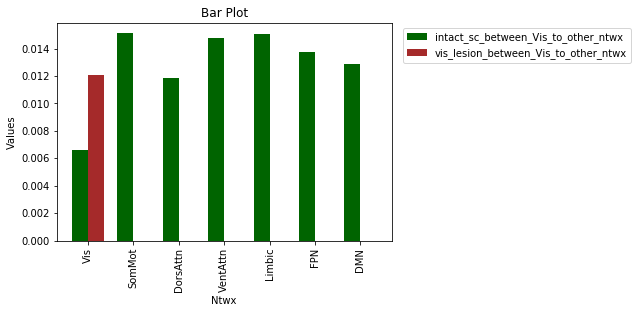

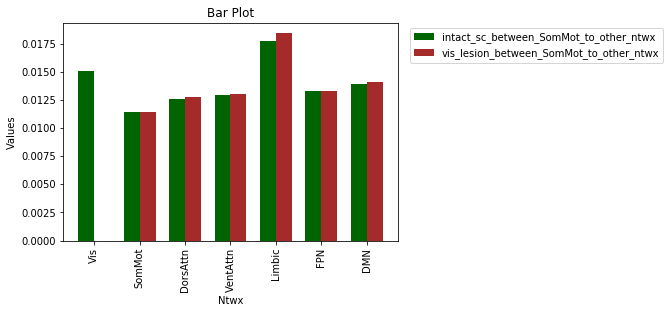

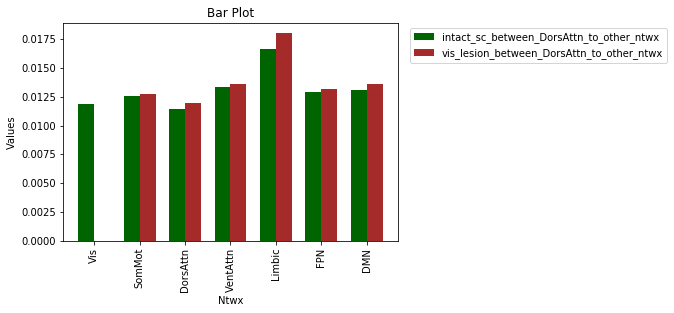

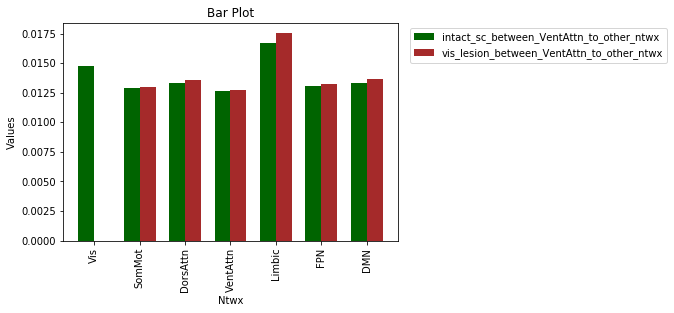

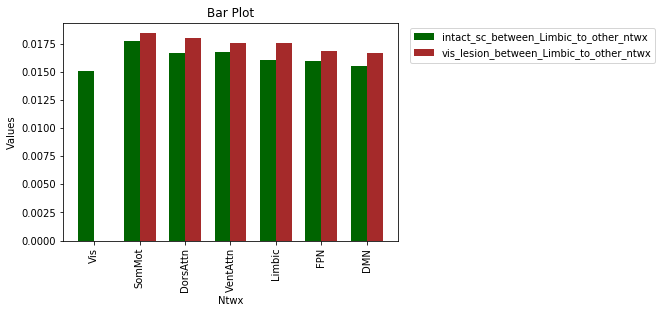

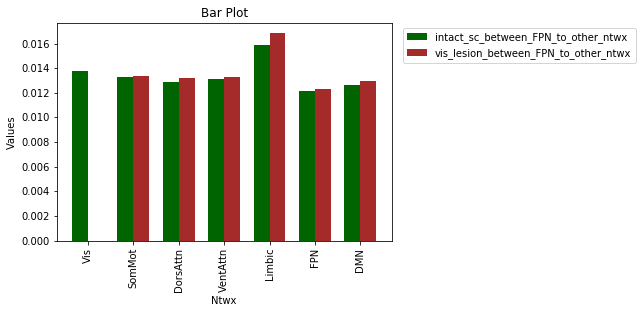

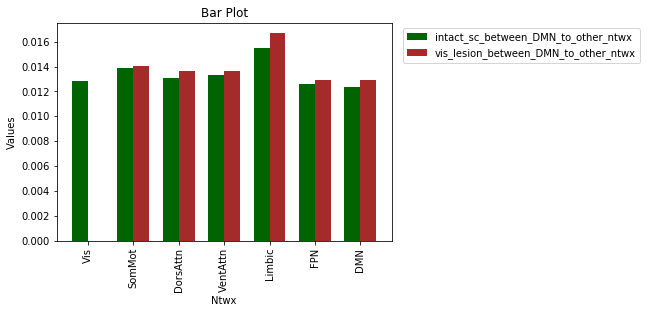

In [268]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='darkgreen')
    rects2 = ax.bar([i + width for i in x], vis_lesion_between_other_ntwx[j], width, label='vis_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='brown')
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

### smt plots

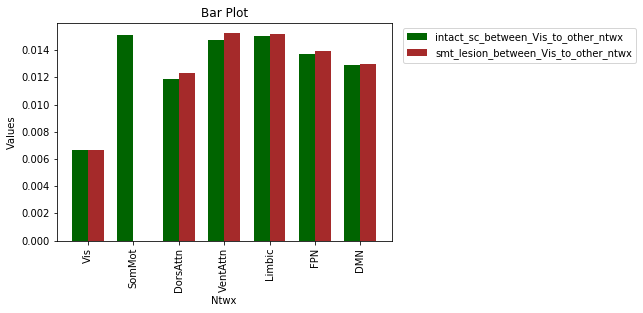

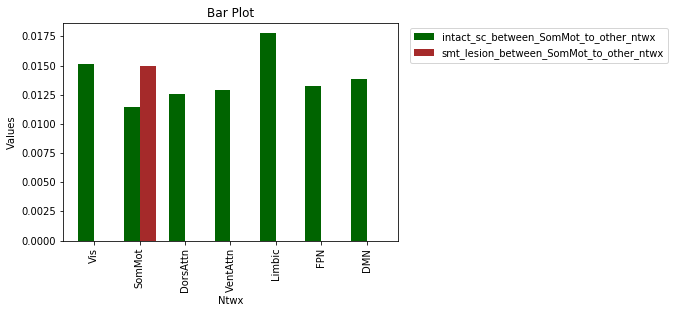

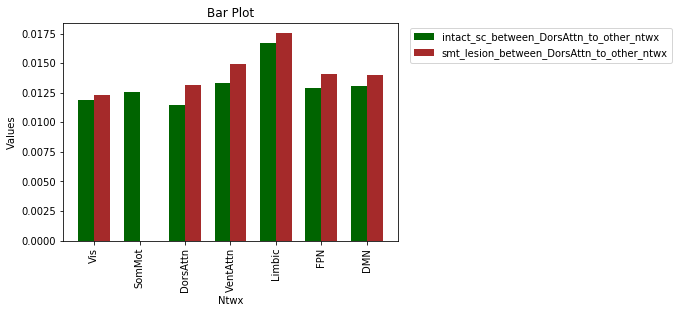

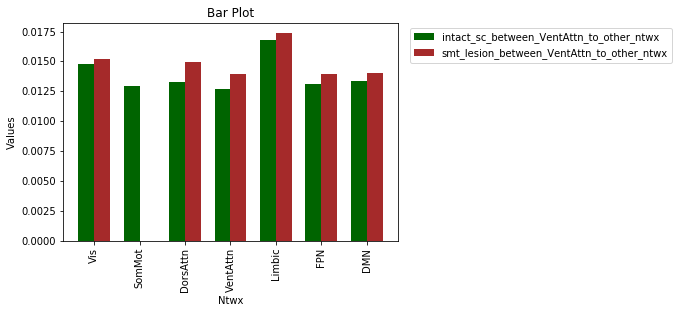

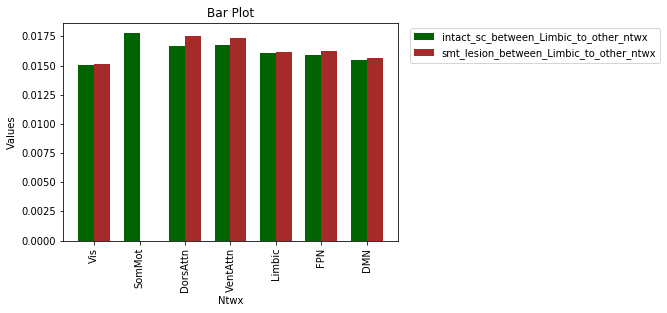

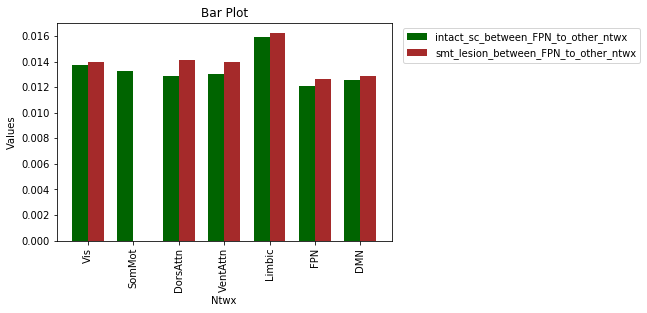

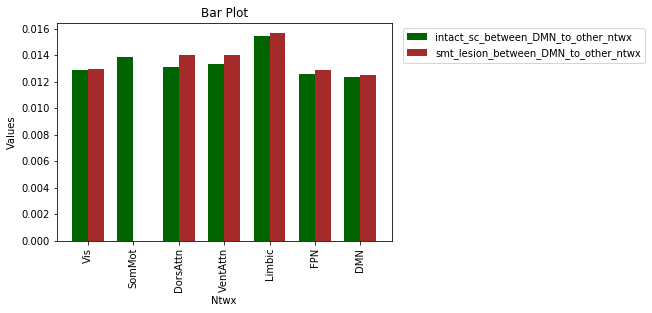

In [272]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='darkgreen')
    rects2 = ax.bar([i + width for i in x], smt_lesion_between_other_ntwx[j], width, label='smt_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='brown')
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

### dan plots

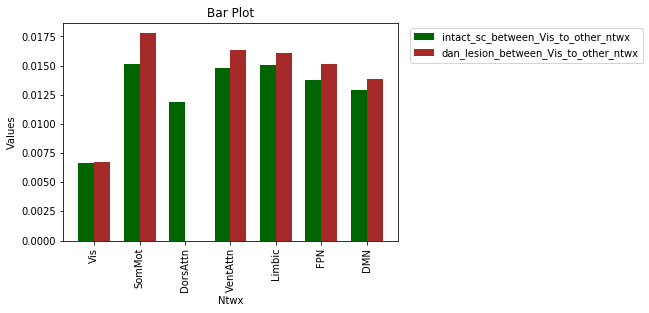

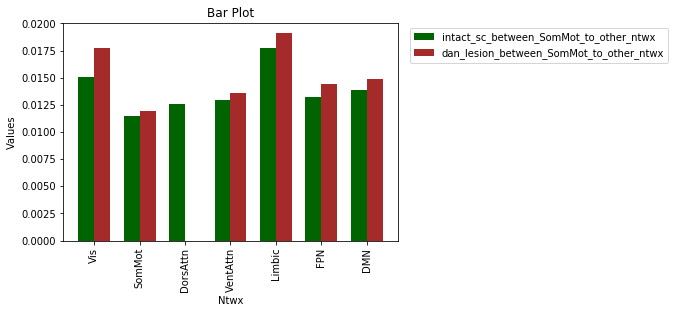

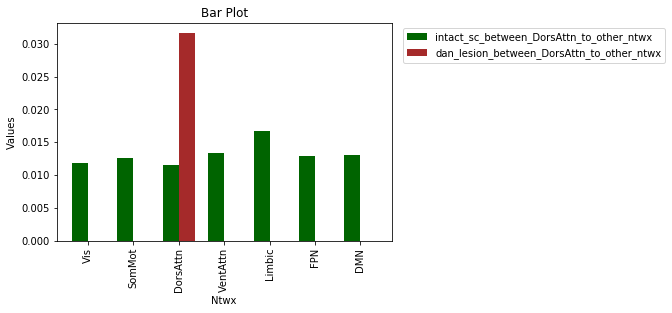

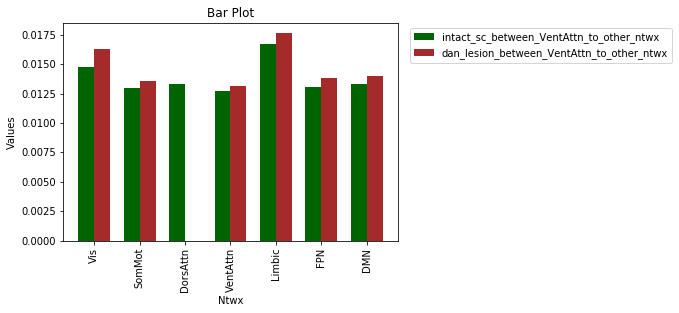

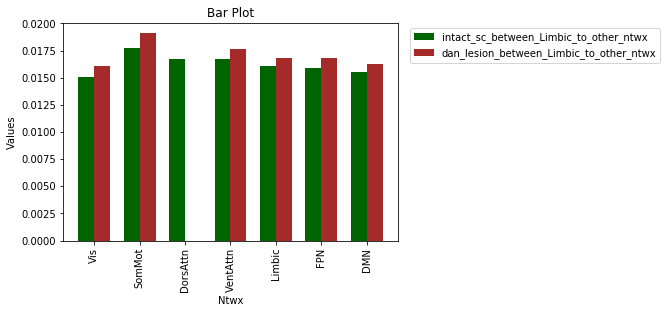

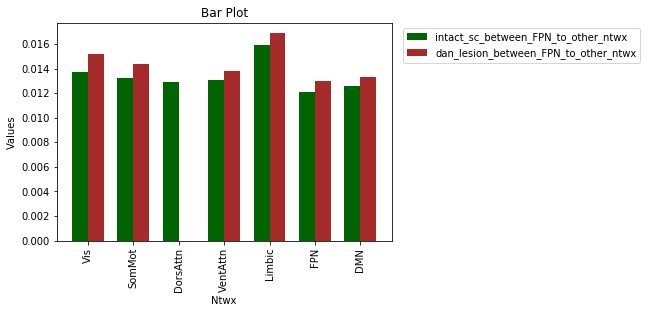

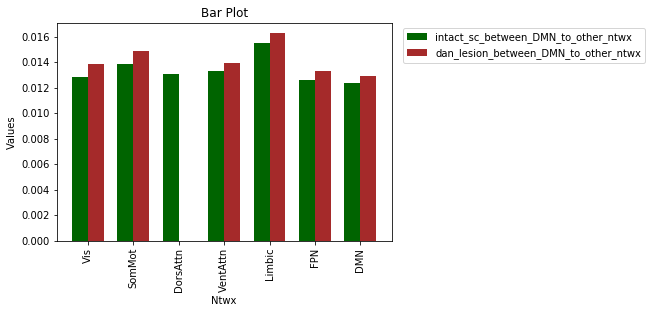

In [273]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='darkgreen')
    rects2 = ax.bar([i + width for i in x], dan_lesion_between_other_ntwx[j], width, label='dan_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='brown')
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

### van plots

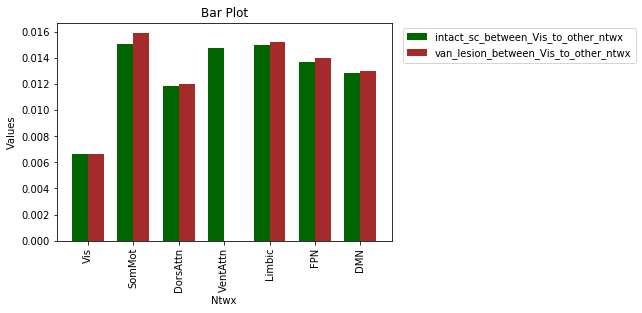

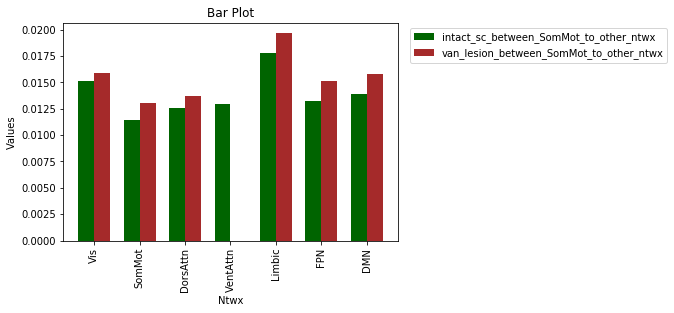

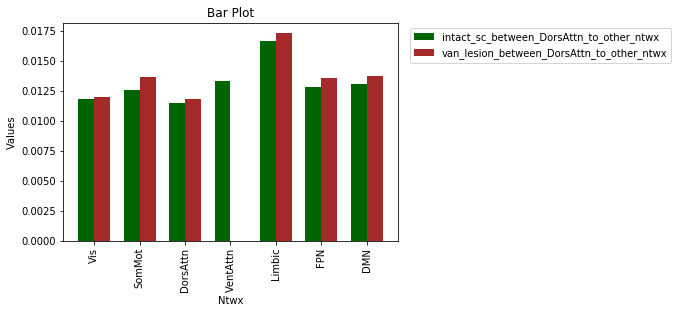

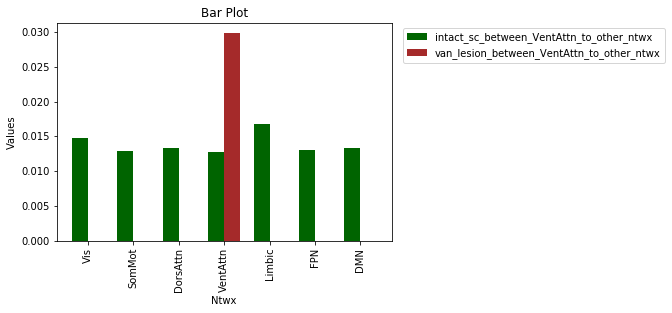

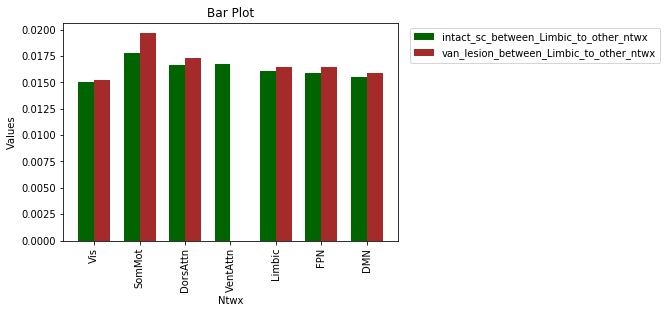

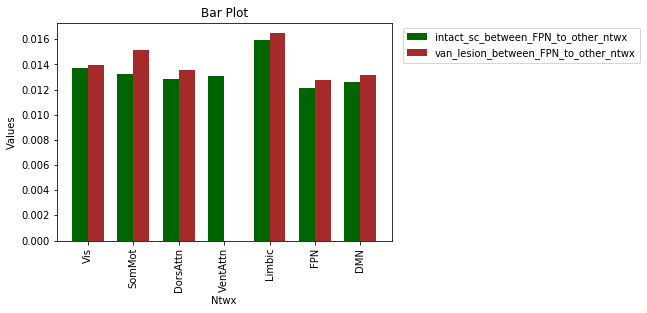

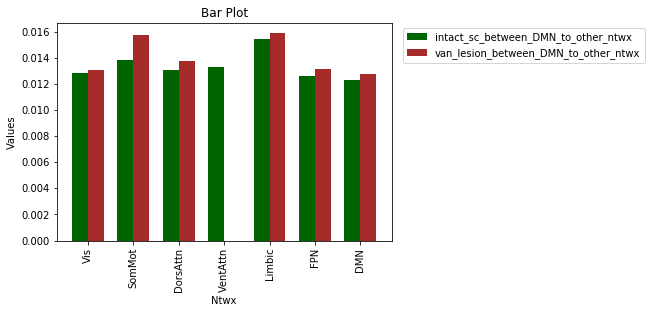

In [274]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='darkgreen')
    rects2 = ax.bar([i + width for i in x], van_lesion_between_other_ntwx[j], width, label='van_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='brown')
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

### lim plots

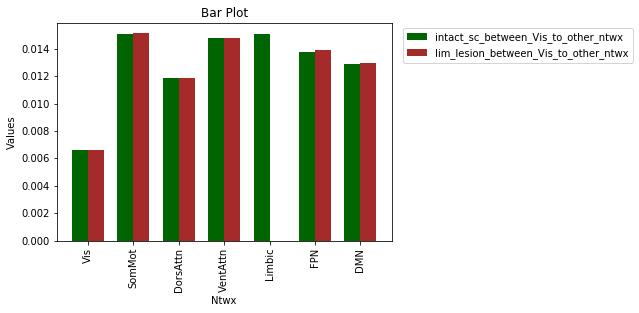

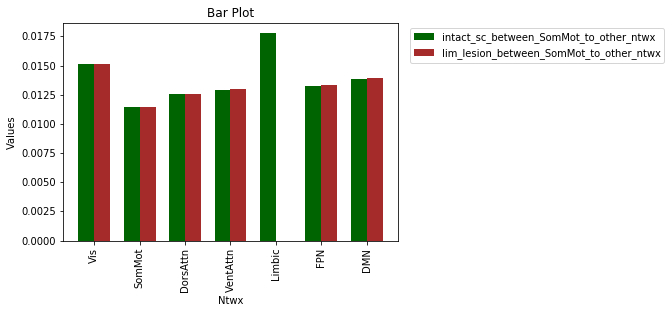

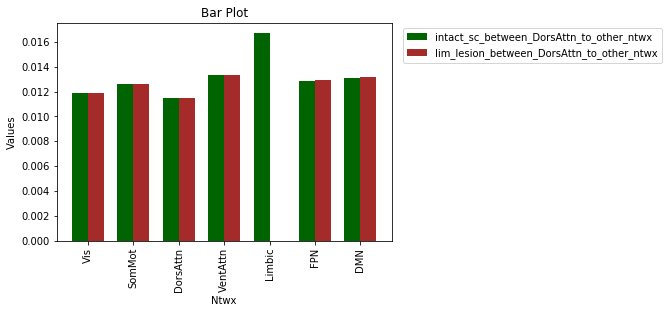

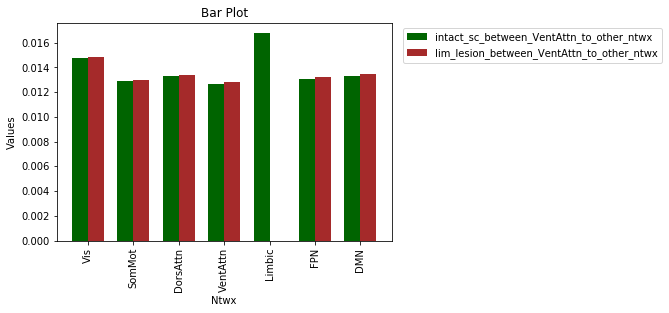

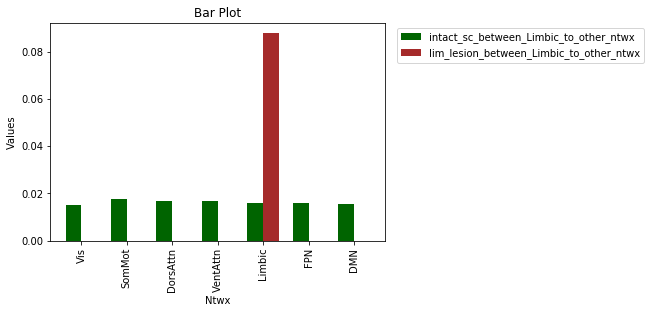

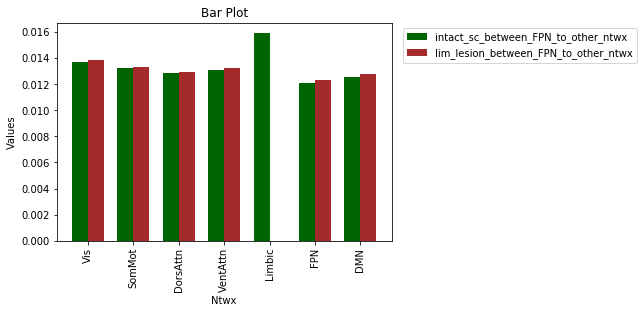

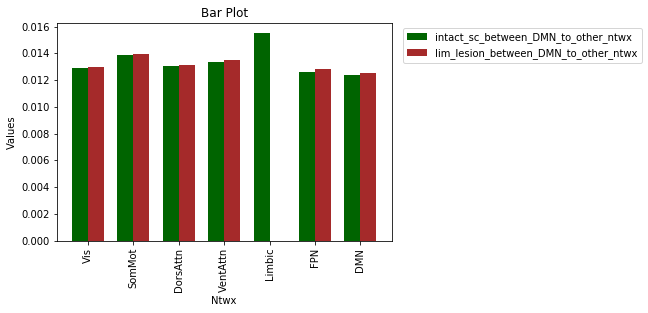

In [275]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='darkgreen')
    rects2 = ax.bar([i + width for i in x], lim_lesion_between_other_ntwx[j], width, label='lim_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='brown')
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

### fpn plots

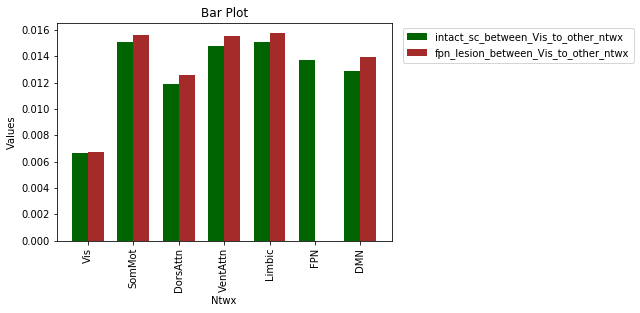

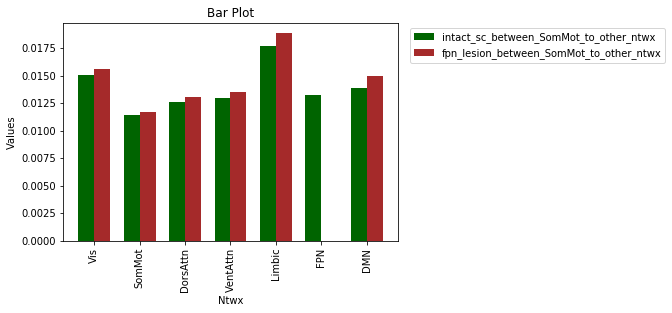

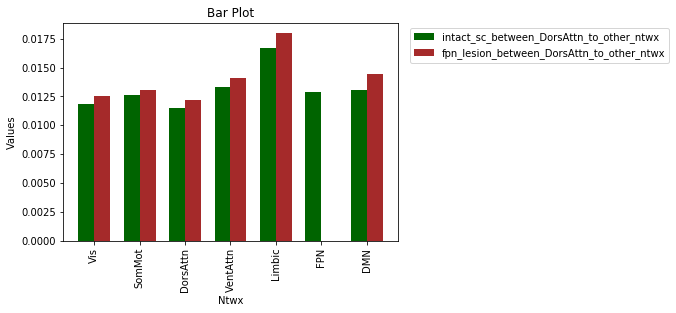

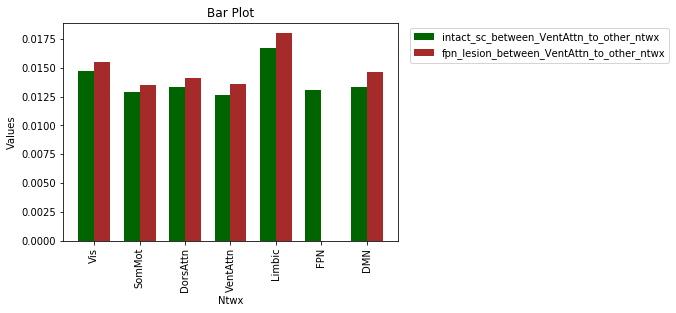

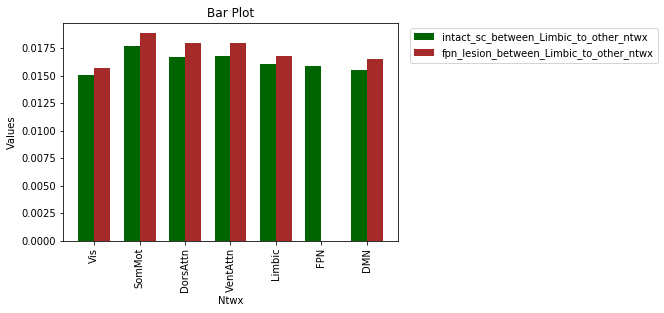

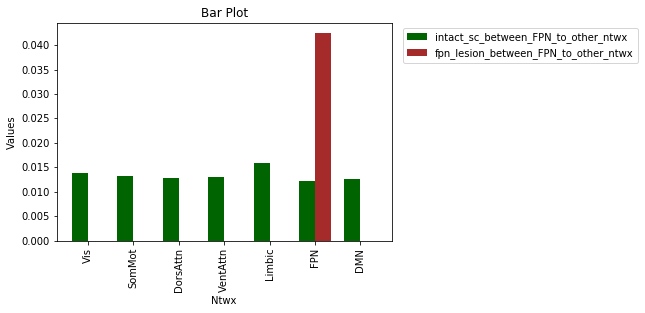

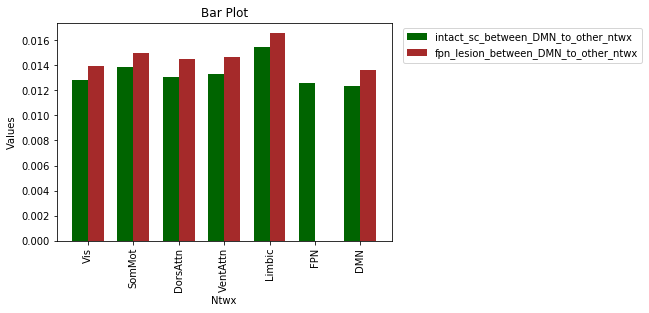

In [276]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='darkgreen')
    rects2 = ax.bar([i + width for i in x], fpn_lesion_between_other_ntwx[j], width, label='fpn_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='brown')
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

### dmn plots

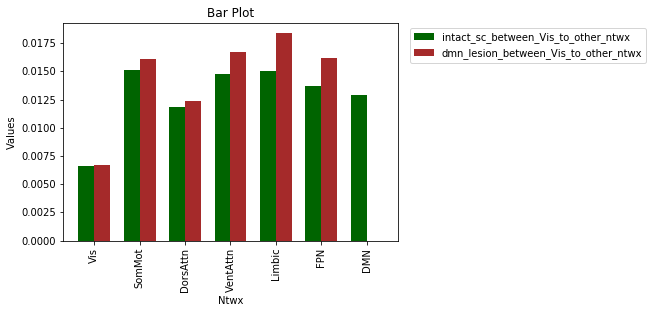

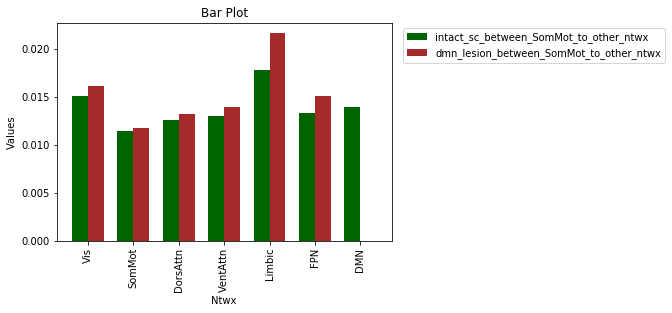

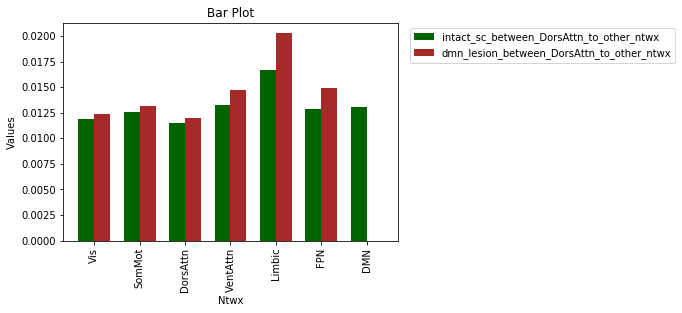

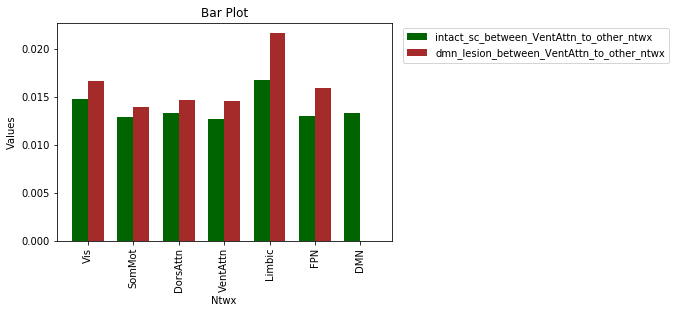

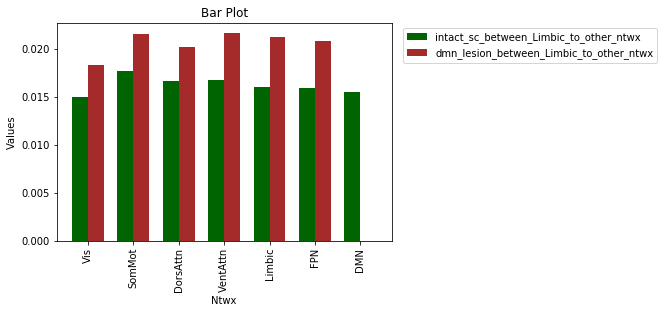

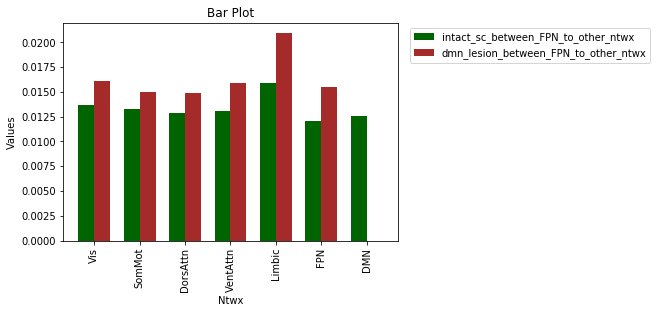

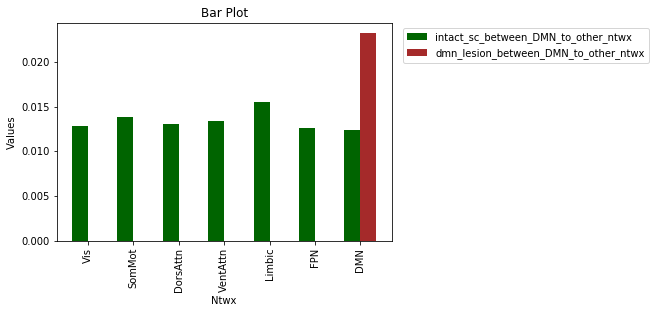

In [277]:
for j in range(7):
    x = range(0,7)  # X-axis values (indices of the lists)
    width = 0.35  # Width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, intact_sc_between_other_ntwx[j], width, label='intact_sc_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='darkgreen')
    rects2 = ax.bar([i + width for i in x], dmn_lesion_between_other_ntwx[j], width, label='dmn_lesion_between_{0}_to_other_ntwx'.format(Ntwx_labels[j]),color='brown')
    # Adding labels, title, and legend
    ax.set_xlabel('Ntwx')
    ax.set_ylabel('Values')
    ax.set_title('Bar Plot')
    ax.set_xticks([i + width/2 for i in x])
    ax.set_xticklabels(Ntwx_labels)
    plt.xticks(rotation=90)
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

    # Displaying the plot
    plt.show()

### testing out the theory ...

In [ ]:
# labels[73:100] dmn lh

# labels[181:200] dmn rh

In [153]:
dmn_lh = np.arange(73,100)
dmn_rh = np.arange(181,200)

In [154]:
dmn_lhrh = np.concatenate((dmn_lh,dmn_rh))

In [159]:
dmn_lhrh = dmn_lhrh.tolist()

In [160]:
dmn_sources = random.sample(dmn_lhrh, 10)
print(dmn_sources)

dmn_targets = []
while len(dmn_targets) < 10:
    num = random.choice(dmn_lhrh)
    if num not in dmn_sources and num not in dmn_targets:
        dmn_targets.append(num)

print(dmn_targets)

[86, 73, 80, 196, 92, 182, 193, 98, 189, 93]
[199, 187, 90, 192, 76, 87, 181, 194, 77, 99]


In [163]:
sub_idx = random.randint(0,200)
print(sub_idx)

157


In [169]:
for i in range(10):
    D = all_subs_pre_lap_SC[sub_idx]
    G = nx.Graph(1 / D)
    source_node = dmn_sources[i]
    target_node = dmn_targets[i]
    print('source: ',labels[source_node])
    print('target: ',labels[target_node])
    print('\n')

    shortest_path_length = nx.shortest_path_length(G, source=source_node, target=target_node, weight='weight')
    print("Shortest path length:", shortest_path_length)
    print('\n')
    shortest_path = nx.shortest_path(G, source=source_node, target=target_node, weight='weight')
    print("Shortest path:", shortest_path)

    print('\n')

    for j in range(len(shortest_path)):
        print(labels[shortest_path[j]])
    print('\n')
    print('Total Hops = ', len(shortest_path)-1)
    print('\n')
    print('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= \n')

source:  7Networks_LH_Default_PFC_5
target:  7Networks_RH_Default_pCunPCC_3


Shortest path length: 0.0032393522795873906


Shortest path: [86, 65, 67, 50, 90, 94, 180, 179, 198, 199]


7Networks_LH_Default_PFC_5
7Networks_LH_Cont_PFCl_1
7Networks_LH_Cont_PFCl_3
7Networks_LH_SalVentAttn_PFCl_1
7Networks_LH_Default_PFC_9
7Networks_LH_Default_PFC_13
7Networks_RH_Cont_PFCmp_2
7Networks_RH_Cont_PFCmp_1
7Networks_RH_Default_pCunPCC_2
7Networks_RH_Default_pCunPCC_3


Total Hops =  9


=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= 

source:  7Networks_LH_Default_Temp_1
target:  7Networks_RH_Default_Temp_4


Shortest path length: 0.005627891403272471


Shortest path: [73, 1, 6, 12, 113, 111, 105, 107, 104, 134, 167, 185, 187]


7Networks_LH_Default_Temp_1
7Networks_LH_Vis_2
7Networks_LH_Vis_7
7Networks_LH_Vis_13
7Networks_RH_Vis_14
7Networks_RH_Vis_12
7Networks_RH_Vis_6
7Networks_RH_Vis_8
7Networks_RH_Vis_5
7Networks_RH_DorsAttn_Post_1
7Networks_RH_Cont_Temp_1
7Networks_RH_Default_Temp_2
7Netw

In [170]:
for i in range(10):
    D = all_subs_sc_dmn_lesion[sub_idx]
    G = nx.Graph(1 / D)
    source_node = dmn_sources[i]
    target_node = dmn_targets[i]
    print('source: ',labels[source_node])
    print('target: ',labels[target_node])
    print('\n')

    shortest_path_length = nx.shortest_path_length(G, source=source_node, target=target_node, weight='weight')
    print("Shortest path length:", shortest_path_length)
    print('\n')
    shortest_path = nx.shortest_path(G, source=source_node, target=target_node, weight='weight')
    print("Shortest path:", shortest_path)

    print('\n')

    for j in range(len(shortest_path)):
        print(labels[shortest_path[j]])
    print('\n')
    print('Total Hops = ', len(shortest_path)-1)
    print('\n')
    print('=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= \n')

source:  7Networks_LH_Default_PFC_5
target:  7Networks_RH_Default_pCunPCC_3


Shortest path length: 0.007396638947576106


Shortest path: [86, 90, 88, 193, 191, 197, 198, 199]


7Networks_LH_Default_PFC_5
7Networks_LH_Default_PFC_9
7Networks_LH_Default_PFC_7
7Networks_RH_Default_PFCdPFCm_4
7Networks_RH_Default_PFCdPFCm_2
7Networks_RH_Default_pCunPCC_1
7Networks_RH_Default_pCunPCC_2
7Networks_RH_Default_pCunPCC_3


Total Hops =  7


=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= 

source:  7Networks_LH_Default_Temp_1
target:  7Networks_RH_Default_Temp_4


Shortest path length: 0.0073219389223001165


Shortest path: [73, 82, 85, 88, 193, 194, 189, 185, 187]


7Networks_LH_Default_Temp_1
7Networks_LH_Default_PFC_1
7Networks_LH_Default_PFC_4
7Networks_LH_Default_PFC_7
7Networks_RH_Default_PFCdPFCm_4
7Networks_RH_Default_PFCdPFCm_5
7Networks_RH_Default_PFCv_1
7Networks_RH_Default_Temp_2
7Networks_RH_Default_Temp_4


Total Hops =  8


=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-= 

source:  7

In [171]:
import plotly.express as px
import plotly.graph_objects as go

In [180]:
# import plotly.express as px
# import plotly.graph_objects as go

# Assuming 'coordinates' is your [200, 3] list of coordinates
coordinates = coords.copy()  # Your data here
specific_indices = [193, 194, 195, 175, 134, 135, 181]
specific_indices_lesion = [193, 194, 189, 185, 182, 181]
# Convert the 'coordinates' list to a NumPy array
coordinates = np.array(coordinates)

# Create separate arrays for specific and non-specific coordinates
specific_coords = coordinates[specific_indices]

specific_coords_lesion = coordinates[specific_indices_lesion]

# other_indices = np.setdiff1d(np.arange(len(coordinates)), specific_indices)
other_indices = np.setdiff1d(np.arange(len(coordinates)), np.concatenate((specific_indices, specific_indices_lesion)))

other_coords = coordinates[other_indices]

# Create scatter plot for specific coordinates (red)
fig = go.Figure(data=[
    go.Scatter3d(
        x=specific_coords_lesion[:, 0],
        y=specific_coords_lesion[:, 1],
        z=specific_coords_lesion[:, 2],
        mode='markers',
        marker=dict(color='red', opacity=0.9,size=5),
        name='Shortest path lesion coords'
    ),
    go.Scatter3d(
        x=specific_coords[:, 0],
        y=specific_coords[:, 1],
        z=specific_coords[:, 2],
        mode='markers',
        marker=dict(color='green', opacity=0.7,size=5),
        name='Shortest path coords'
    ),
    
    go.Scatter3d(
        x=other_coords[:, 0],
        y=other_coords[:, 1],
        z=other_coords[:, 2],
        mode='markers',
        marker=dict(color='grey', opacity=0.9,size=3),
#         name='-'
    ),
    go.Scatter3d(
        x=specific_coords_lesion[:, 0],
        y=specific_coords_lesion[:, 1],
        z=specific_coords_lesion[:, 2],
        mode='lines',
        line=dict(color='red', width=4),
        name='Shortest lesion Path'
    ),
    go.Scatter3d(
        x=specific_coords[:, 0],
        y=specific_coords[:, 1],
        z=specific_coords[:, 2],
        mode='lines',
        line=dict(color='green', width=3),
        name='Shortest Path'
    )
    
])

# Set the layout
fig.update_layout(scene=dict(aspectmode='data'), title='3D Scatter Plot')

# Show the interactive plot
fig.show()

In [286]:
len(intact_sc_all_subs_between_other_ntwx[0])
# vis_lesion_all_subs_between_other_ntwx

200

# stats

In [209]:
import statsmodels.api as sm
import pingouin as pg

### `vis` stats

In [319]:
intact_vis_only = [xx[0] for xx in intact_sc_all_subs_between_other_ntwx[0]]

lesion_vis_only = [yy[0] for yy in vis_lesion_all_subs_between_other_ntwx[0]]

t_stat, p_val = stats.ttest_rel(intact_vis_only, lesion_vis_only)
    
print(t_stat, p_val)

-1.0925245902303606 0.27592343999639085


In [306]:
for i in range(7):
    
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    condition_A = intact_sc_all_subs_between_other_ntwx[i].copy()
    condition_A = [[value for k, value in enumerate(sublist) if k != 0] for sublist in condition_A]
    
    condition_B = vis_lesion_all_subs_between_other_ntwx[i].copy()
    condition_B = [[value for m, value in enumerate(sublist) if m != 0] for sublist in condition_B]
    
    t_stat, p_val = stats.ttest_rel(condition_A, condition_B)
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    

    print(p_val_formatted)
    print(p_val)
    
    print('--------------------- \n')

Vis to other ntwx stats 

[6.01104064 6.46505929 6.20698129 6.94932396 6.37424393 6.54093155]
['0.0000000087', '0.0000000008', '0.0000000031', '0.0000000001', '0.0000000013', '0.0000000005']
[8.66445729e-09 7.65732837e-10 3.08266020e-09 5.12184324e-11
 1.25503573e-09 5.05112774e-10]
--------------------- 

SomMot to other ntwx stats 

[-5.46522451 -9.94596857 -6.28125011 -5.4523214  -5.90542897 -5.13974837]
['0.0000001373', '0.0000000000', '0.0000000021', '0.0000001463', '0.0000000150', '0.0000006550']
[1.37347161e-07 3.54618273e-19 2.07221695e-09 1.46304984e-07
 1.49900845e-08 6.54992823e-07]
--------------------- 

DorsAttn to other ntwx stats 

[ -9.94596857 -12.95649557 -11.0146131   -6.31760526  -9.80151512
  -8.3784702 ]
['0.0000000000', '0.0000000000', '0.0000000000', '0.0000000017', '0.0000000000', '0.0000000000']
[3.54618273e-19 3.06222818e-28 2.45106336e-22 1.70424868e-09
 9.32507049e-19 9.58355060e-15]
--------------------- 

VentAttn to other ntwx stats 

[ -6.28125011 -11.

### `smt` stats

In [318]:
intact_smt_only = [xx[0] for xx in intact_sc_all_subs_between_other_ntwx[1]]

lesion_smt_only = [yy[0] for yy in smt_lesion_all_subs_between_other_ntwx[1]]

t_stat, p_val = stats.ttest_rel(intact_smt_only, lesion_smt_only)
    
print(t_stat, p_val)

6.011040641967367 8.66445728588366e-09


In [317]:
for i in range(7):
    
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    condition_A = intact_sc_all_subs_between_other_ntwx[i].copy()
    condition_A = [[value for k, value in enumerate(sublist) if k != 1] for sublist in condition_A]
    
    condition_B = smt_lesion_all_subs_between_other_ntwx[i].copy()
    condition_B = [[value for m, value in enumerate(sublist) if m != 1] for sublist in condition_B]
    
    t_stat, p_val = stats.ttest_rel(condition_A, condition_B)
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    

    print(p_val_formatted)
    print(p_val)
    
    print('--------------------- \n')

Vis to other ntwx stats 

[ -1.53073938  -9.63792702 -14.23029629  -6.32350331  -4.68703
  -6.75888851]
['0.1274219107', '0.0000000000', '0.0000000000', '0.0000000017', '0.0000051349', '0.0000000002']
[1.27421911e-01 2.77142776e-18 3.69423676e-32 1.65093578e-09
 5.13491936e-06 1.50424457e-10]
--------------------- 

SomMot to other ntwx stats 

[6.01104064 5.81667409 5.59500184 6.11677692 6.03218726 6.04565075]
['0.0000000087', '0.0000000236', '0.0000000723', '0.0000000050', '0.0000000078', '0.0000000072']
[8.66445729e-09 2.36449409e-08 7.23429054e-08 4.97374542e-09
 7.75794934e-09 7.22992440e-09]
--------------------- 

DorsAttn to other ntwx stats 

[-9.63792702 -9.83510791 -9.75737747 -9.010245   -7.29278325 -9.47550469]
['0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000']
[2.77142776e-18 7.45047376e-19 1.25183938e-18 1.70215170e-16
 7.03170600e-12 8.12203960e-18]
--------------------- 

VentAttn to other ntwx stats 

[-14.23029629  -9.757

### `dan` stats

In [321]:
intact_dan_only = [xx[0] for xx in intact_sc_all_subs_between_other_ntwx[2]]

lesion_dan_only = [yy[0] for yy in dan_lesion_all_subs_between_other_ntwx[2]]

t_stat, p_val = stats.ttest_rel(intact_dan_only, lesion_dan_only)
    
print(t_stat, p_val)

6.465059288491554 7.657328367491874e-10


In [328]:
for i in range(7):
    
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    condition_A = intact_sc_all_subs_between_other_ntwx[i].copy()
    condition_A = [[value for k, value in enumerate(sublist) if k != 2] for sublist in condition_A]
    
    condition_B = dan_lesion_all_subs_between_other_ntwx[i].copy()
    condition_B = [[value for m, value in enumerate(sublist) if m != 2] for sublist in condition_B]
    
    t_stat, p_val = stats.ttest_rel(condition_A, condition_B)
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    

    print(p_val_formatted)
    print(p_val)
    
    print('--------------------- \n')

Vis to other ntwx stats 

[-3.99926128 -6.45113666 -6.75403269 -9.5289593  -6.55579415 -6.18851049]
['0.0000895347', '0.0000000008', '0.0000000002', '0.0000000000', '0.0000000005', '0.0000000034']
[8.95347461e-05 8.26217482e-10 1.54578758e-10 5.70547420e-18
 4.65418630e-10 3.40113562e-09]
--------------------- 

SomMot to other ntwx stats 

[-6.45113666 -5.26271219 -6.32495309 -5.76965401 -6.86001241 -6.22226495]
['0.0000000008', '0.0000003659', '0.0000000016', '0.0000000300', '0.0000000001', '0.0000000028']
[8.26217482e-10 3.65869221e-07 1.63808391e-09 3.00468804e-08
 8.50744549e-11 2.84141318e-09]
--------------------- 

DorsAttn to other ntwx stats 

[6.46505929 5.81667409 6.03875242 6.4881876  6.27011481 6.38964647]
['0.0000000008', '0.0000000236', '0.0000000075', '0.0000000007', '0.0000000022', '0.0000000012']
[7.65732837e-10 2.36449409e-08 7.49591397e-09 6.74735002e-10
 2.19977853e-09 1.15450111e-09]
--------------------- 

VentAttn to other ntwx stats 

[-6.75403269 -6.32495309 

### `van` stats

In [324]:
intact_van_only = [xx[0] for xx in intact_sc_all_subs_between_other_ntwx[3]]

lesion_van_only = [yy[0] for yy in van_lesion_all_subs_between_other_ntwx[3]]

t_stat, p_val = stats.ttest_rel(intact_van_only, lesion_van_only)
    
print(t_stat, p_val)

6.20698128826883 3.082660196409838e-09


In [329]:
for i in range(7):
    
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    condition_A = intact_sc_all_subs_between_other_ntwx[i].copy()
    condition_A = [[value for k, value in enumerate(sublist) if k != 3] for sublist in condition_A]
    
    condition_B = van_lesion_all_subs_between_other_ntwx[i].copy()
    condition_B = [[value for m, value in enumerate(sublist) if m != 3] for sublist in condition_B]
    
    t_stat, p_val = stats.ttest_rel(condition_A, condition_B)
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    

    print(p_val_formatted)
    print(p_val)
    
    print('--------------------- \n')

Vis to other ntwx stats 

[ -1.30754461  -9.7755121  -13.63418629  -7.16420515  -8.64857122
 -11.85599877]
['0.1925364286', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000']
[1.92536429e-01 1.10923486e-18 2.52635631e-30 1.48801821e-11
 1.73688144e-15 7.07247719e-25]
--------------------- 

SomMot to other ntwx stats 

[-9.7755121  -5.64046547 -7.01671261 -8.70767483 -7.09156852 -6.96414083]
['0.0000000000', '0.0000000577', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000']
[1.10923486e-18 5.76524447e-08 3.48392880e-11 1.19151604e-15
 2.26515324e-11 4.70660910e-11]
--------------------- 

DorsAttn to other ntwx stats 

[-13.63418629  -7.01671261  -7.86276842  -9.6827588   -7.21703284
  -7.73520108]
['0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000', '0.0000000000']
[2.52635631e-30 3.48392880e-11 2.32975860e-13 2.05745268e-18
 1.09455818e-11 5.05199794e-13]
--------------------- 

VentAttn to other ntwx stats 

[6.20

### `lim` stats

In [327]:
intact_lim_only = [xx[0] for xx in intact_sc_all_subs_between_other_ntwx[4]]

lesion_lim_only = [yy[0] for yy in lim_lesion_all_subs_between_other_ntwx[4]]

t_stat, p_val = stats.ttest_rel(intact_lim_only, lesion_lim_only)
    
print(t_stat, p_val)

6.949323955619215 5.1218432408586566e-11


In [331]:
for i in range(7):
    
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    condition_A = intact_sc_all_subs_between_other_ntwx[i].copy()
    condition_A = [[value for k, value in enumerate(sublist) if k != 4] for sublist in condition_A]
    
    condition_B = lim_lesion_all_subs_between_other_ntwx[i].copy()
    condition_B = [[value for m, value in enumerate(sublist) if m != 4] for sublist in condition_B]
    
    t_stat, p_val = stats.ttest_rel(condition_A, condition_B)
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    

    print(p_val_formatted)
    print(p_val)
    
    print('--------------------- \n')

Vis to other ntwx stats 

[ -1.20605581  -2.55201781  -2.79653155  -6.74659605 -11.64501233
  -9.4749264 ]
['0.2292279141', '0.0114606600', '0.0056720729', '0.0000000002', '0.0000000000', '0.0000000000']
[2.29227914e-01 1.14606600e-02 5.67207288e-03 1.61160928e-10
 3.08826667e-24 8.15309808e-18]
--------------------- 

SomMot to other ntwx stats 

[ -2.55201781  -2.46371728  -3.24352606  -7.22545831 -11.70346538
  -8.87556165]
['0.0114606600', '0.0145991852', '0.0013846086', '0.0000000000', '0.0000000000', '0.0000000000']
[1.14606600e-02 1.45991852e-02 1.38460860e-03 1.04212036e-11
 2.05380476e-24 4.06106994e-16]
--------------------- 

DorsAttn to other ntwx stats 

[ -2.79653155  -3.24352606  -3.56850148  -9.86339744 -14.16036348
 -11.87409967]
['0.0056720729', '0.0013846086', '0.0004499254', '0.0000000000', '0.0000000000', '0.0000000000']
[5.67207288e-03 1.38460860e-03 4.49925395e-04 6.16621299e-19
 6.06434311e-32 6.23110677e-25]
--------------------- 

VentAttn to other ntwx stats 

### `fpn` stats

In [332]:
intact_fpn_only = [xx[0] for xx in intact_sc_all_subs_between_other_ntwx[5]]

lesion_fpn_only = [yy[0] for yy in fpn_lesion_all_subs_between_other_ntwx[5]]

t_stat, p_val = stats.ttest_rel(intact_fpn_only, lesion_fpn_only)
    
print(t_stat, p_val)

6.3742439311701515 1.2550357306041037e-09


In [333]:
for i in range(7):
    
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    condition_A = intact_sc_all_subs_between_other_ntwx[i].copy()
    condition_A = [[value for k, value in enumerate(sublist) if k != 5] for sublist in condition_A]
    
    condition_B = fpn_lesion_all_subs_between_other_ntwx[i].copy()
    condition_B = [[value for m, value in enumerate(sublist) if m != 5] for sublist in condition_B]
    
    t_stat, p_val = stats.ttest_rel(condition_A, condition_B)
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    

    print(p_val_formatted)
    print(p_val)
    
    print('--------------------- \n')

Vis to other ntwx stats 

[-2.73633216 -5.75258866 -6.02590099 -8.26367337 -6.17971832 -4.66194009]
['0.0067748898', '0.0000000328', '0.0000000080', '0.0000000000', '0.0000000036', '0.0000057326']
[6.77488977e-03 3.27664222e-08 8.01725305e-09 1.96596629e-14
 3.56385720e-09 5.73263879e-06]
--------------------- 

SomMot to other ntwx stats 

[-5.75258866 -2.44541238 -4.80025712 -3.50397469 -4.21842887 -4.26747974]
['0.0000000328', '0.0153381779', '0.0000031075', '0.0005661135', '0.0000373504', '0.0000305666']
[3.27664222e-08 1.53381779e-02 3.10753261e-06 5.66113497e-04
 3.73503980e-05 3.05665694e-05]
--------------------- 

DorsAttn to other ntwx stats 

[-6.02590099 -4.80025712 -6.45049211 -5.68427187 -4.85418872 -4.8198128 ]
['0.0000000080', '0.0000031075', '0.0000000008', '0.0000000463', '0.0000024390', '0.0000028468']
[8.01725305e-09 3.10753261e-06 8.29128540e-10 4.62730228e-08
 2.43896193e-06 2.84684542e-06]
--------------------- 

VentAttn to other ntwx stats 

[-8.26367337 -3.503

### `dmn` stats

In [334]:
intact_dmn_only = [xx[0] for xx in intact_sc_all_subs_between_other_ntwx[6]]

lesion_dmn_only = [yy[0] for yy in dmn_lesion_all_subs_between_other_ntwx[6]]

t_stat, p_val = stats.ttest_rel(intact_dmn_only, lesion_dmn_only)
    
print(t_stat, p_val)

6.540931548720853 5.051127742950446e-10


In [335]:
for i in range(7):
    
    print('{0} to other ntwx stats \n'.format(Ntwx_labels[i]))
    
    condition_A = intact_sc_all_subs_between_other_ntwx[i].copy()
    condition_A = [[value for k, value in enumerate(sublist) if k != 6] for sublist in condition_A]
    
    condition_B = fpn_lesion_all_subs_between_other_ntwx[i].copy()
    condition_B = [[value for m, value in enumerate(sublist) if m != 6] for sublist in condition_B]
    
    t_stat, p_val = stats.ttest_rel(condition_A, condition_B)
    
    print(t_stat)
    
    p_val_formatted = []
    for p_value in p_val:
        formatted_p_value = f"{p_value:.10f}"  
        p_val_formatted.append(formatted_p_value)
    

    print(p_val_formatted)
    print(p_val)
    
    print('--------------------- \n')

Vis to other ntwx stats 

[-2.73633216 -5.75258866 -6.02590099 -8.26367337 -6.17971832  6.37424393]
['0.0067748898', '0.0000000328', '0.0000000080', '0.0000000000', '0.0000000036', '0.0000000013']
[6.77488977e-03 3.27664222e-08 8.01725305e-09 1.96596629e-14
 3.56385720e-09 1.25503573e-09]
--------------------- 

SomMot to other ntwx stats 

[-5.75258866 -2.44541238 -4.80025712 -3.50397469 -4.21842887  6.03218726]
['0.0000000328', '0.0153381779', '0.0000031075', '0.0005661135', '0.0000373504', '0.0000000078']
[3.27664222e-08 1.53381779e-02 3.10753261e-06 5.66113497e-04
 3.73503980e-05 7.75794934e-09]
--------------------- 

DorsAttn to other ntwx stats 

[-6.02590099 -4.80025712 -6.45049211 -5.68427187 -4.85418872  6.27011481]
['0.0000000080', '0.0000031075', '0.0000000008', '0.0000000463', '0.0000024390', '0.0000000022']
[8.01725305e-09 3.10753261e-06 8.29128540e-10 4.62730228e-08
 2.43896193e-06 2.19977853e-09]
--------------------- 

VentAttn to other ntwx stats 

[-8.26367337 -3.503